# Setup

## Imports

In [1]:
import QuantumToolbox as qt
import SuperconductingCavities as SC
import CairoMakie as cm
using Revise
using Dates
import JSON3

using ProgressMeter

import Optim as opt

using Logging
using MiniLoggers

┌ Info: new driver key :netcdf, updating backendlist.
└ @ NetCDFExt /home/gr400/.julia/packages/YAXArrayBase/Xj43k/ext/NetCDFExt.jl:81


## Logger Setups

In [2]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(ProgressLogger)

Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(21) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Info, Dict{Any, Int64}())

# Loading Model and json

In [3]:
Mode1 = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode1/Mode1.json");
proj_dict = SC.Utils.Get_Projection_Ops(Mode1.dressed_states);

device_config = JSON3.read("device_config_files/config_multimode.json", Dict{Any, Any});

In [4]:
GLOBAL_SAVE_CALIBRATE = true;

# Calibrating Pulses

## Qubit Pulses

### Guasisan g -> e

In [5]:
println("Target σ: "*string(device_config["device"]["soc"]["qubit"]["pulses"]["pi_ge"]["sigma"]))

Target σ: 0.023251488095238096


#### Getting Stark Shift

[2024-11-08 12:18:10] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


[2024-11-08 12:18:21] Info: Done With Floquet Sweep
[2024-11-08 12:18:22] Info: Fit Stuff: 3-element Vector{Float64}:	 0.0003602406721609811	 0.008952900754221395	 2.00670418634113
Stark shift res: [0.0003602406721609811, 55.66123947861645]


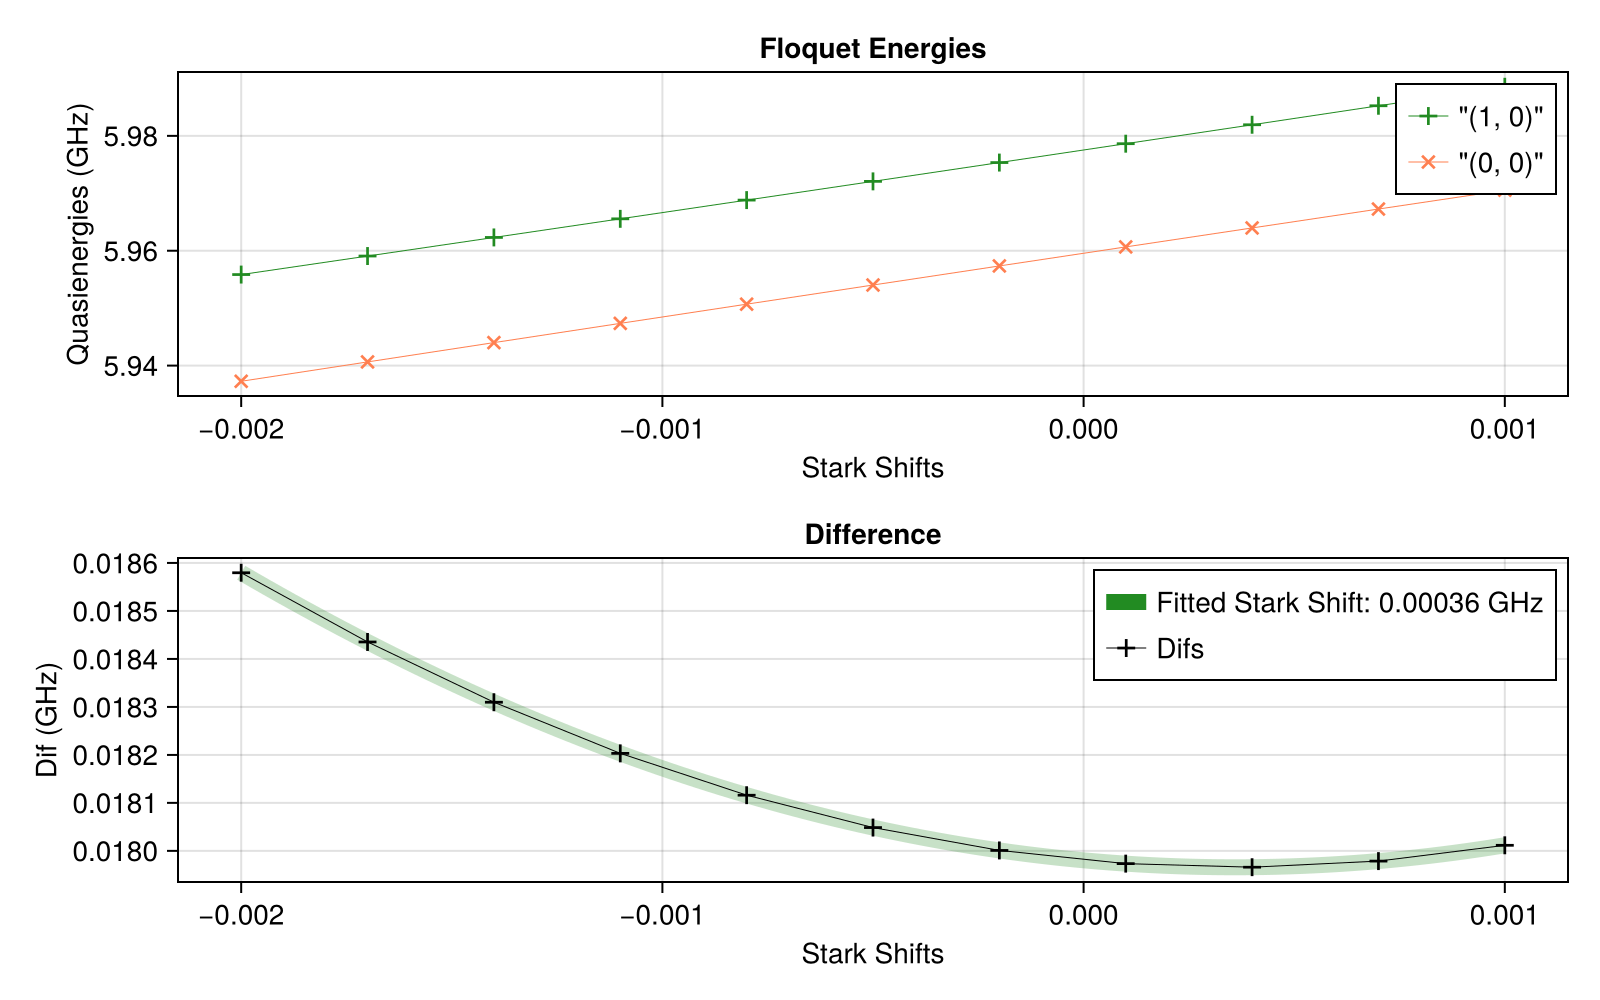

In [6]:
ge_ε = 0.00538
drive_op = Mode1.n̂ₜ
state1 = (0,0)
state2 = (1,0)

stark_shift_list = collect(LinRange(-0.002, 0.001, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode1, state1, state2, ge_ε, stark_shift_list)
println("Stark shift res: "*string(stark_shift_res))
ge_stark_shift = stark_shift_res[1];

#### $|1,0\rangle+|0,1\rangle \to |0,0\rangle+|1,1\rangle$

In [7]:

ψ1 = Mode1.dressed_states[(1,0)]+Mode1.dressed_states[(0,1)]
ψ1 = ψ1/qt.norm(ψ1)

ψ2 = Mode1.dressed_states[(0,0)]+Mode1.dressed_states[(1,1)]
ψ2 = ψ2/qt.norm(ψ2)

freq_d_e0 = Mode1.dressed_energies[(1,0)]-Mode1.dressed_energies[(0,0)]+ge_stark_shift
freq_d_g1 = Mode1.dressed_energies[(1,1)]-Mode1.dressed_energies[(0,1)]+ge_stark_shift

freq_d = (freq_d_e0+freq_d_g1)/2

check_op = proj_dict[(0,0)]+proj_dict[(1,1)]

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

#qubit_ε = qubit_ε

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge_half = SC.Dynamics.OptimizePulse(Mode1, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5, check_op = check_op)


[2024-11-08 12:18:34] Info: On Level 1
[2024-11-08 12:18:34] Info: On Step 1: t = 90.0
[2024-11-08 12:18:34] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-08 12:18:38] Info: Time Evolution Complete
[2024-11-08 12:18:38] Info: Done with Level_1_step_1
[2024-11-08 12:18:38] Info: Accurace: 0.9967857520180913
[2024-11-08 12:18:38] Info: ------------------------------------------------------------------------------
[2024-11-08 12:18:38] Info: On Step 2: t = 92.5
[2024-11-08 12:18:38] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 12:18:39] Info: Time Evolution Complete
[2024-11-08 12:18:39] Info: Done with Level_1_step_2
[2024-11-08 12:18:39] Info: Accurace: 0.9992445908618334
[2024-11-08 12:18:39] Info: ------------------------------------------------------------------------------
[2024-11-08 12:18:39] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999308
  "freq_d"        => 4.6044

In [8]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode1.Stuff["op_drive_params"]["q_ge_1/2"] = deepcopy(qubit_ge_half)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999308
  "freq_d"        => 4.6044

In [9]:
ψ = Mode1.dressed_states[(1,0)]+Mode1.dressed_states[(0,1)]
ψ = ψ/qt.norm(ψ)
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ge_half_res = SC.Dynamics.RunPulseSequence(Mode1, ψ, ["q_ge_1/2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T12:19:23.162
It is being saved at: Data/
[2024-11-08 12:19:23] Info: Running operator q_ge_1/2
[2024-11-08 12:19:23] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-08 12:19:25] Info: Time Evolution Complete
[2024-11-08 12:19:25] Info: Saving Steps
[2024-11-08 12:19:30] Info: Done with Step_1
[2024-11-08 12:19:30] Info: Done With Running Sequence
[2024-11-08 12:19:30] Info: Loading Data


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [10]:
EVs = SC.Utils.Get_EVs(q_ge_half_res["states"], proj_dict);

[2024-11-08 12:19:33] Info: Making Plot


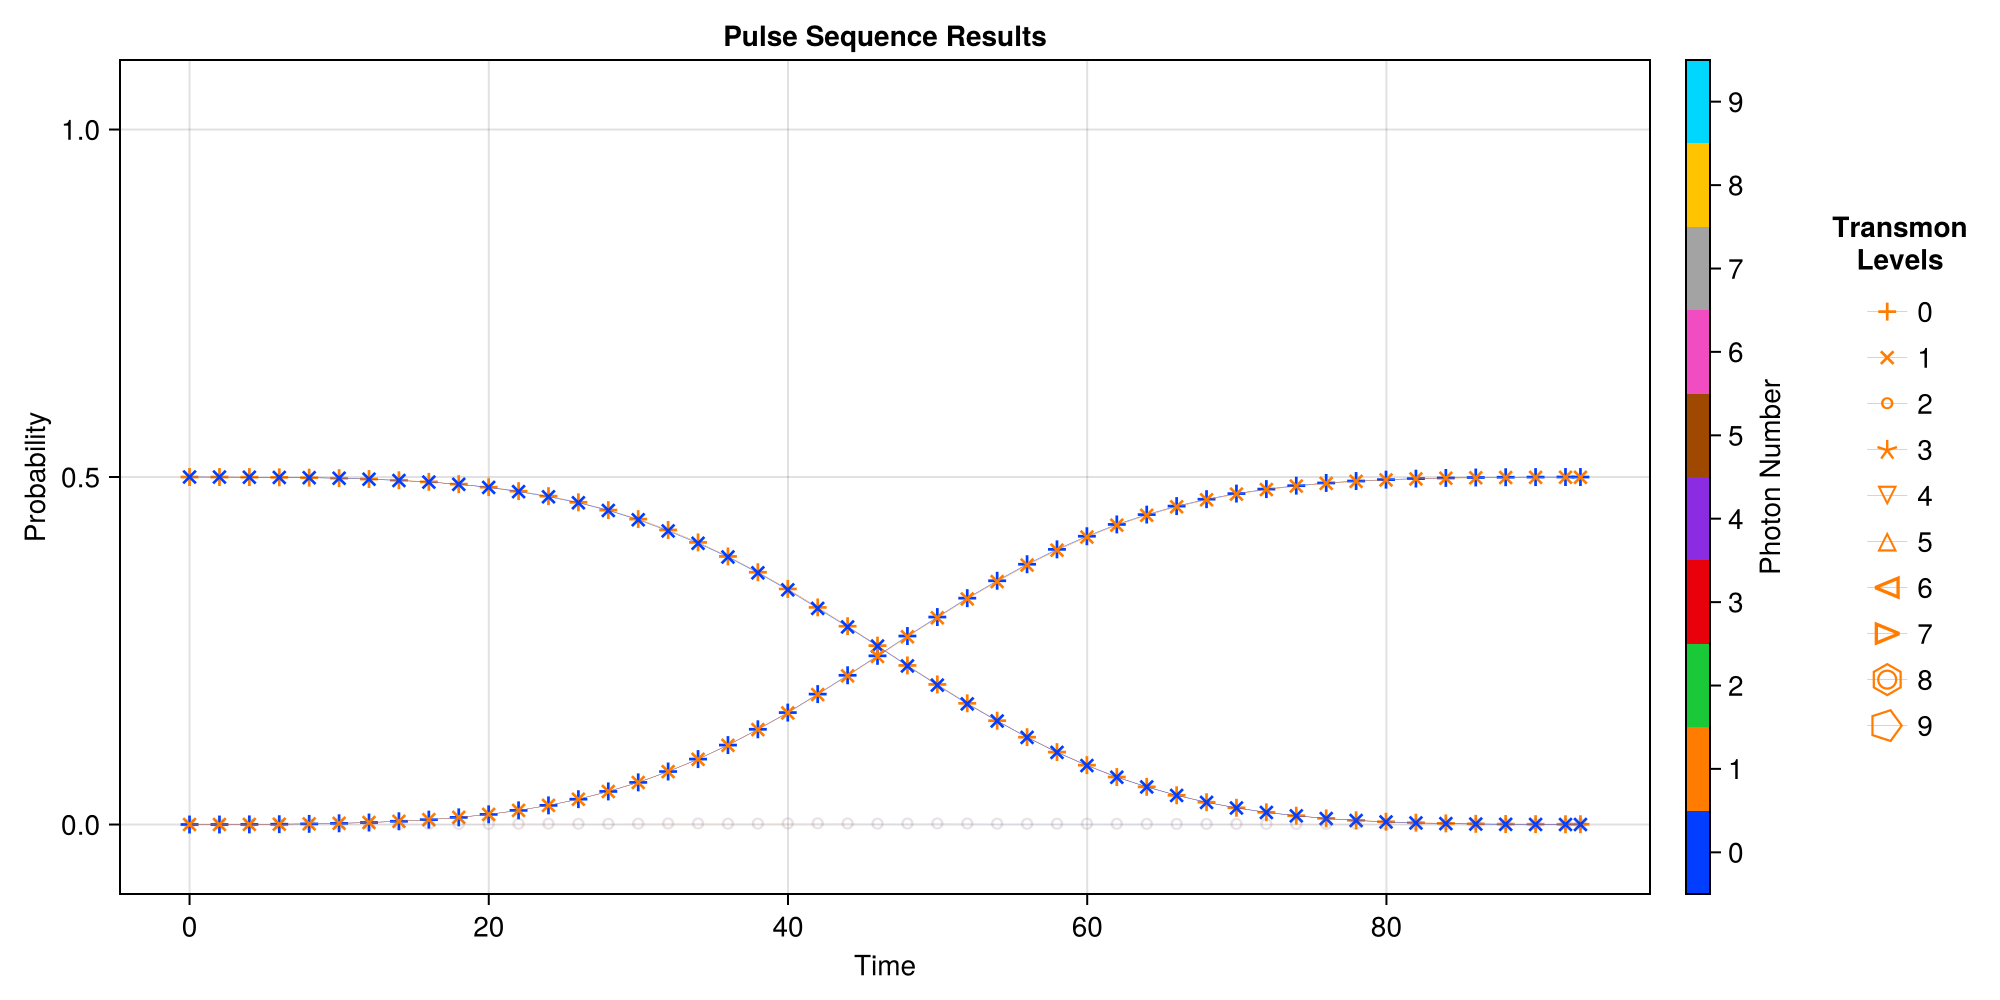

CairoMakie.Screen{IMAGE}


In [11]:
SC.Dynamics.PlotSingleModeEvolution(Mode1, q_ge_half_res["times"], EVs, plot_every = 10, emph_states = [(0,0),(1,0),(0,1),(1,1)])

In [12]:
println(EVs[(0,0)][end])
println(EVs[(1,1)][end])

0.499965736976474 + 2.116971203605704e-17im
0.49958123752579964 - 2.1332553639417727e-17im


In [13]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999997226512827 - 2.4552578064430726e-19im

#### $|0,0\rangle \to |1,0\rangle$

In [14]:
state1 = (0,0)
state2 = (1,0)
ψ1 = Mode1.dressed_states[state1]
ψ2 = Mode1.dressed_states[state2]

freq_d = Mode1.dressed_energies[state2]-Mode1.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge0_opt_res = SC.Dynamics.OptimizePulse(Mode1, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-08 12:19:38] Info: On Level 1
[2024-11-08 12:19:38] Info: On Step 1: t = 90.0
[2024-11-08 12:19:38] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 12:19:40] Info: Time Evolution Complete
[2024-11-08 12:19:40] Info: Done with Level_1_step_1
[2024-11-08 12:19:40] Info: Accurace: 0.9968478721803431
[2024-11-08 12:19:40] Info: ------------------------------------------------------------------------------
[2024-11-08 12:19:40] Info: On Step 2: t = 92.5
[2024-11-08 12:19:40] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 12:19:41] Info: Time Evolution Complete
[2024-11-08 12:19:41] Info: Done with Level_1_step_2
[2024-11-08 12:19:41] Info: Accurace: 0.9992981097192939
[2024-11-08 12:19:41] Info: ------------------------------------------------------------------------------
[2024-11-08 12:19:41] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999358
  "freq_d"        => 4.60449

In [15]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode1.Stuff["op_drive_params"]["q_ge_0"] = deepcopy(qubit_ge0_opt_res)
end


Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999358
  "freq_d"        => 4.60449

In [16]:
ψ = Mode1.dressed_states[(0,0)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ge0_res = SC.Dynamics.RunPulseSequence(Mode1, ψ, ["q_ge_0"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T12:20:28.467
It is being saved at: Data/
[2024-11-08 12:20:28] Info: Running operator q_ge_0
[2024-11-08 12:20:28] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-08 12:20:32] Info: Time Evolution Complete
[2024-11-08 12:20:32] Info: Saving Steps
[2024-11-08 12:20:32] Info: Done with Step_1
[2024-11-08 12:20:32] Info: Done With Running Sequence
[2024-11-08 12:20:32] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [17]:
EVs_ge0 = SC.Utils.Get_EVs(q_ge0_res["states"], proj_dict);

[2024-11-08 12:20:33] Info: Making Plot


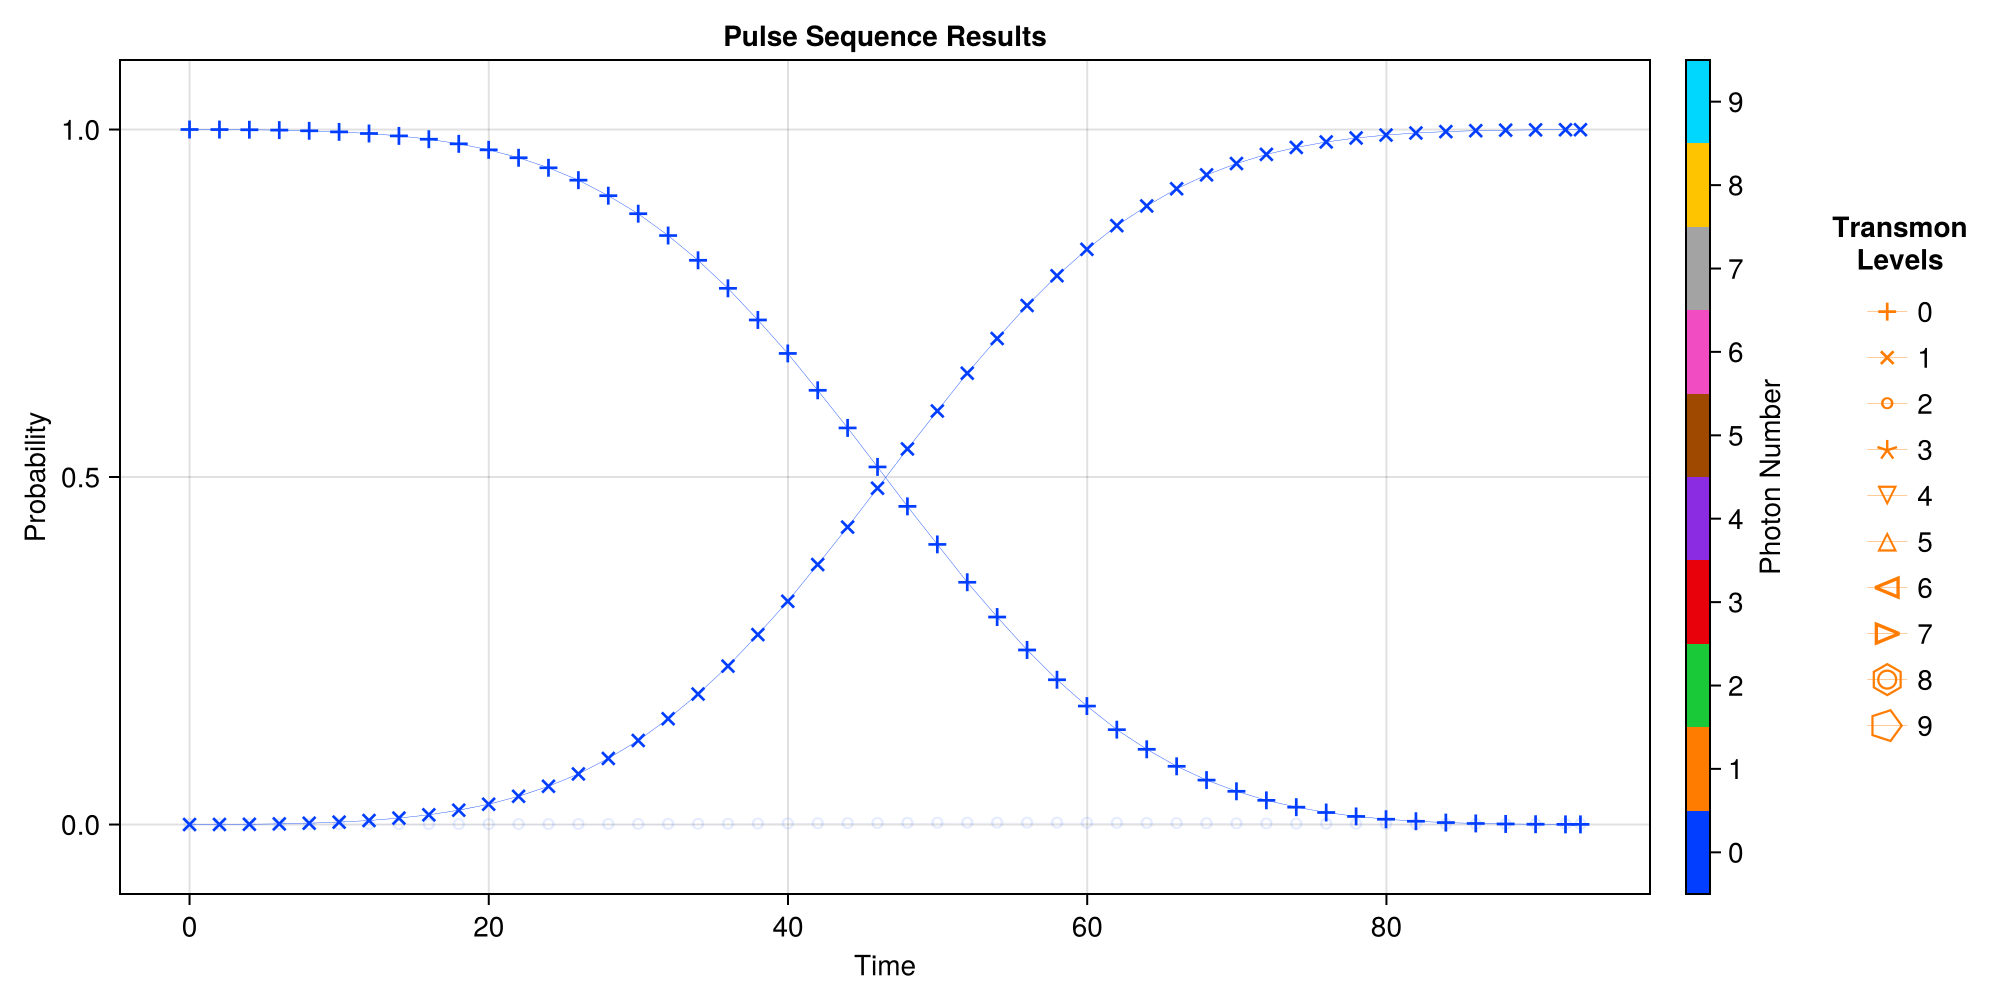

CairoMakie.Screen{IMAGE}


In [18]:
SC.Dynamics.PlotSingleModeEvolution(Mode1, q_ge0_res["times"], EVs_ge0, plot_every = 10, emph_states = [(0,0),(1,0)])

In [19]:
println(EVs_ge0[(0,0)][end])
println(EVs_ge0[(1,0)][end])
println(EVs_ge0[(2,0)][end])

0.000226005654458386 + 1.6867802584483823e-20im
0.9997119171114073 + 3.853751395266864e-19im
6.167178471635688e-5 - 7.886234905275313e-23im


In [20]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999997226512827 - 2.4552578064430726e-19im

#### $|0,1\rangle \to |1,1\rangle$

In [21]:
state1 = (0,1)
state2 = (1,1)
ψ1 = Mode1.dressed_states[state1]
ψ2 = Mode1.dressed_states[state2]

freq_d = Mode1.dressed_energies[state2]-Mode1.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)


t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge1_opt_res = SC.Dynamics.OptimizePulse(Mode1, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-08 12:20:33] Info: On Level 1
[2024-11-08 12:20:33] Info: On Step 1: t = 90.0
[2024-11-08 12:20:33] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 12:20:34] Info: Time Evolution Complete
[2024-11-08 12:20:34] Info: Done with Level_1_step_1
[2024-11-08 12:20:34] Info: Accurace: 0.9970980037092586
[2024-11-08 12:20:34] Info: ------------------------------------------------------------------------------
[2024-11-08 12:20:34] Info: On Step 2: t = 92.5
[2024-11-08 12:20:34] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 12:20:36] Info: Time Evolution Complete
[2024-11-08 12:20:36] Info: Done with Level_1_step_2
[2024-11-08 12:20:36] Info: Accurace: 0.9995754871884243
[2024-11-08 12:20:36] Info: ------------------------------------------------------------------------------
[2024-11-08 12:20:36] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999644
  "freq_d"        => 4.60431

In [22]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode1.Stuff["op_drive_params"]["q_ge_1"] = deepcopy(qubit_ge1_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999644
  "freq_d"        => 4.60431

In [23]:
ψ = Mode1.dressed_states[(0,1)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ge1_res = SC.Dynamics.RunPulseSequence(Mode1, ψ, ["q_ge_1"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T12:21:19.320
It is being saved at: Data/
[2024-11-08 12:21:19] Info: Running operator q_ge_1
[2024-11-08 12:21:19] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-08 12:21:21] Info: Time Evolution Complete
[2024-11-08 12:21:21] Info: Saving Steps
[2024-11-08 12:21:22] Info: Done with Step_1
[2024-11-08 12:21:22] Info: Done With Running Sequence
[2024-11-08 12:21:22] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [24]:
EVs = SC.Utils.Get_EVs(q_ge1_res["states"], proj_dict);

[2024-11-08 12:21:22] Info: Making Plot


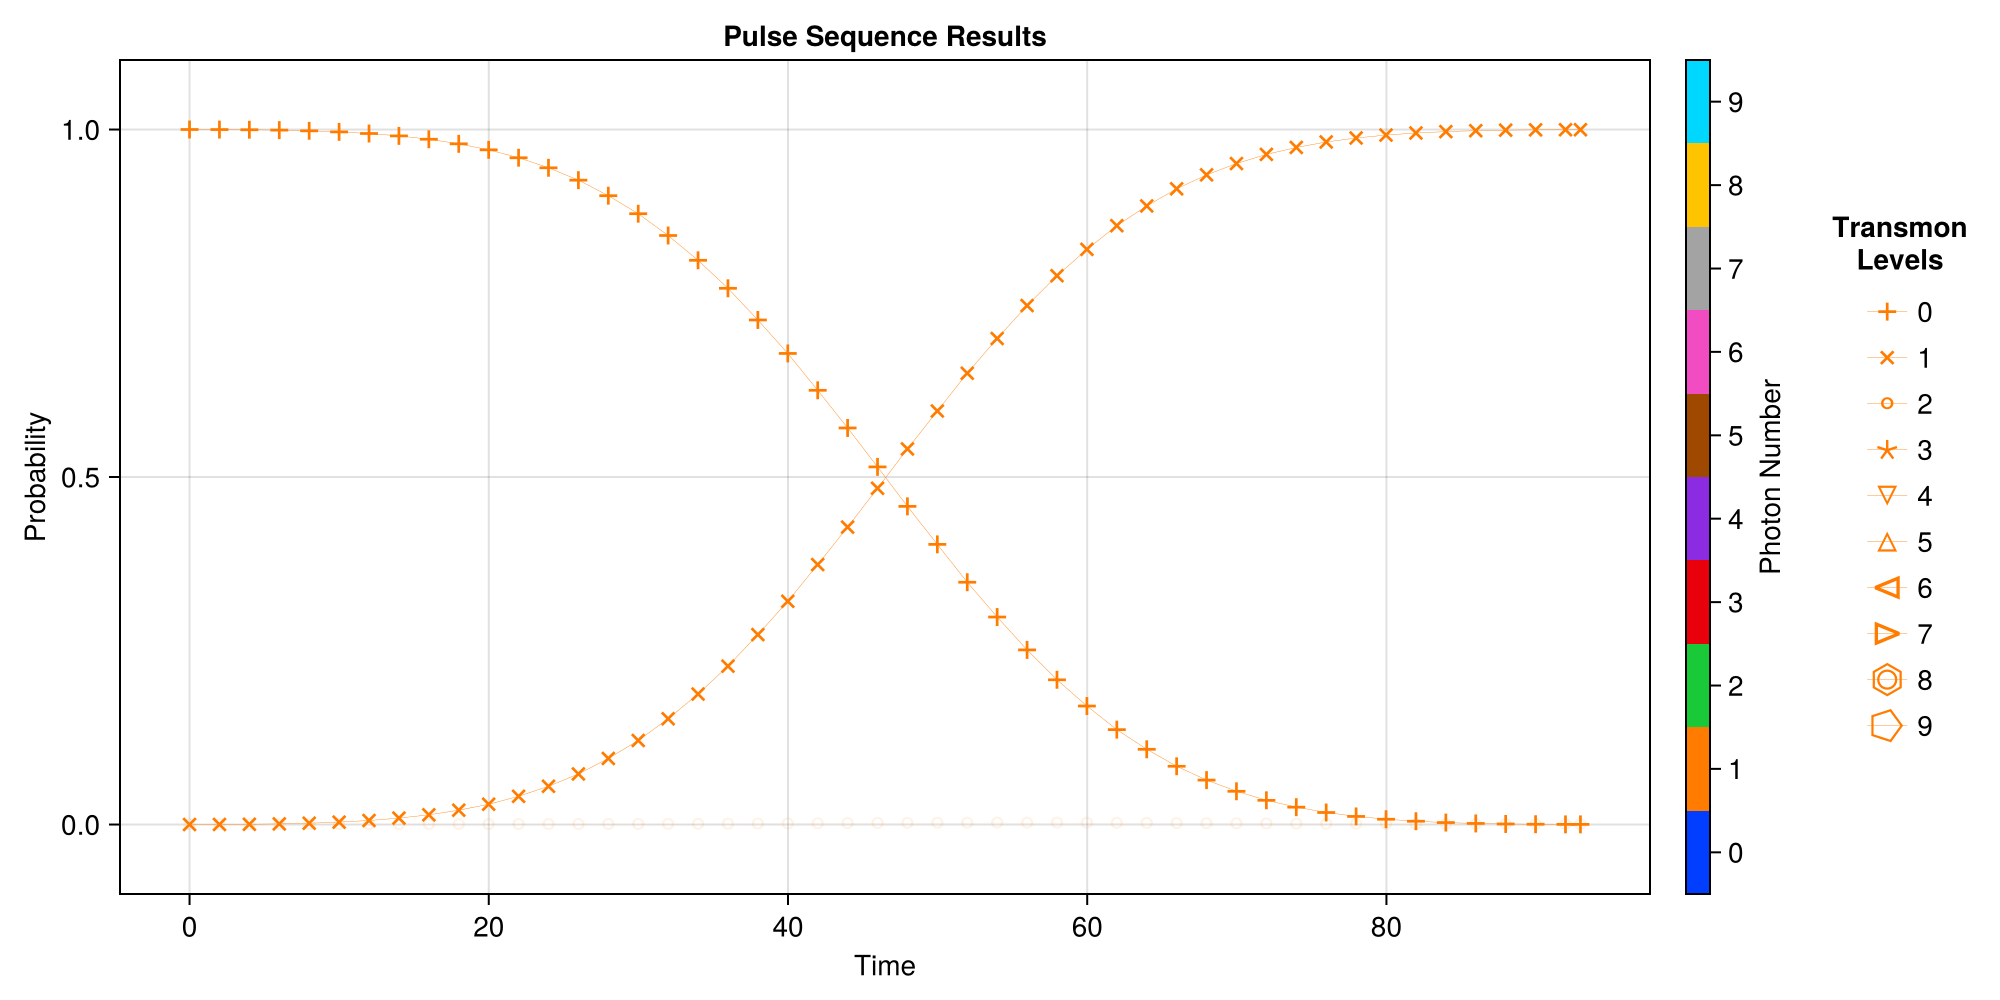

CairoMakie.Screen{IMAGE}


In [25]:
SC.Dynamics.PlotSingleModeEvolution(Mode1, q_ge1_res["times"], EVs, plot_every = 10, emph_states = [(0,1),(1,1)])

In [26]:
EVs[(1,1)][end]

0.9997100884978679 - 7.204207701037626e-17im

In [27]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999974684236156 - 7.147418132617744e-17im

#### $|0,0\rangle+(|1,1\rangle+|0,3\rangle)/\sqrt{2} \to |1,0\rangle+(|0,1\rangle+|1,3\rangle)/\sqrt{2}$

In [28]:

ψ1 = Mode1.dressed_states[(0,0)]+(Mode1.dressed_states[(1,1)]+Mode1.dressed_states[(0,3)])/sqrt(2)
ψ1 = ψ1/qt.norm(ψ1)

ψ2 = Mode1.dressed_states[(1,0)]+(Mode1.dressed_states[(0,1)]+Mode1.dressed_states[(1,3)])/sqrt(2)
ψ2 = ψ2/qt.norm(ψ2)

freq_d_g0 = Mode1.dressed_energies[(1,0)]-Mode1.dressed_energies[(0,0)]+ge_stark_shift
freq_d_g1 = Mode1.dressed_energies[(1,1)]-Mode1.dressed_energies[(0,1)]+ge_stark_shift
freq_d_g3 = Mode1.dressed_energies[(1,3)]-Mode1.dressed_energies[(0,3)]+ge_stark_shift

χ = freq_d_g1-freq_d_g0

freq_d = freq_d_g0+4*χ/3

check_op = proj_dict[(1,0)]+proj_dict[(0,1)]+proj_dict[(1,3)]

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)


t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge_four_thirds_opt_res = SC.Dynamics.OptimizePulse(Mode1, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5, check_op = check_op)


[2024-11-08 12:21:23] Info: On Level 1
[2024-11-08 12:21:23] Info: On Step 1: t = 90.0
[2024-11-08 12:21:23] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 12:21:24] Info: Time Evolution Complete
[2024-11-08 12:21:24] Info: Done with Level_1_step_1
[2024-11-08 12:21:24] Info: Accurace: 0.9962189318635752
[2024-11-08 12:21:24] Info: ------------------------------------------------------------------------------
[2024-11-08 12:21:24] Info: On Step 2: t = 92.5
[2024-11-08 12:21:24] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 12:21:25] Info: Time Evolution Complete
[2024-11-08 12:21:25] Info: Done with Level_1_step_2
[2024-11-08 12:21:25] Info: Accurace: 0.9986280949207353
[2024-11-08 12:21:25] Info: ------------------------------------------------------------------------------
[2024-11-08 12:21:25] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.998686
  "freq_d"        => 4.60425

In [29]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode1.Stuff["op_drive_params"]["q_ge_4/3"] = deepcopy(qubit_ge_four_thirds_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.998686
  "freq_d"        => 4.60425

In [30]:
ψ = Mode1.dressed_states[(1,1)]+(Mode1.dressed_states[(0,0)]+Mode1.dressed_states[(0,3)])/sqrt(2)
ψ = ψ/qt.norm(ψ)
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ge_four_thirds_res = SC.Dynamics.RunPulseSequence(Mode1, ψ, ["q_ge_4/3"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T12:22:11.097
It is being saved at: Data/
[2024-11-08 12:22:11] Info: Running operator q_ge_4/3
[2024-11-08 12:22:11] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-08 12:22:14] Info: Time Evolution Complete
[2024-11-08 12:22:14] Info: Saving Steps
[2024-11-08 12:22:15] Info: Done with Step_1
[2024-11-08 12:22:15] Info: Done With Running Sequence
[2024-11-08 12:22:15] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [31]:
EVs = SC.Utils.Get_EVs(q_ge_four_thirds_res["states"], proj_dict);

[2024-11-08 12:22:15] Info: Making Plot


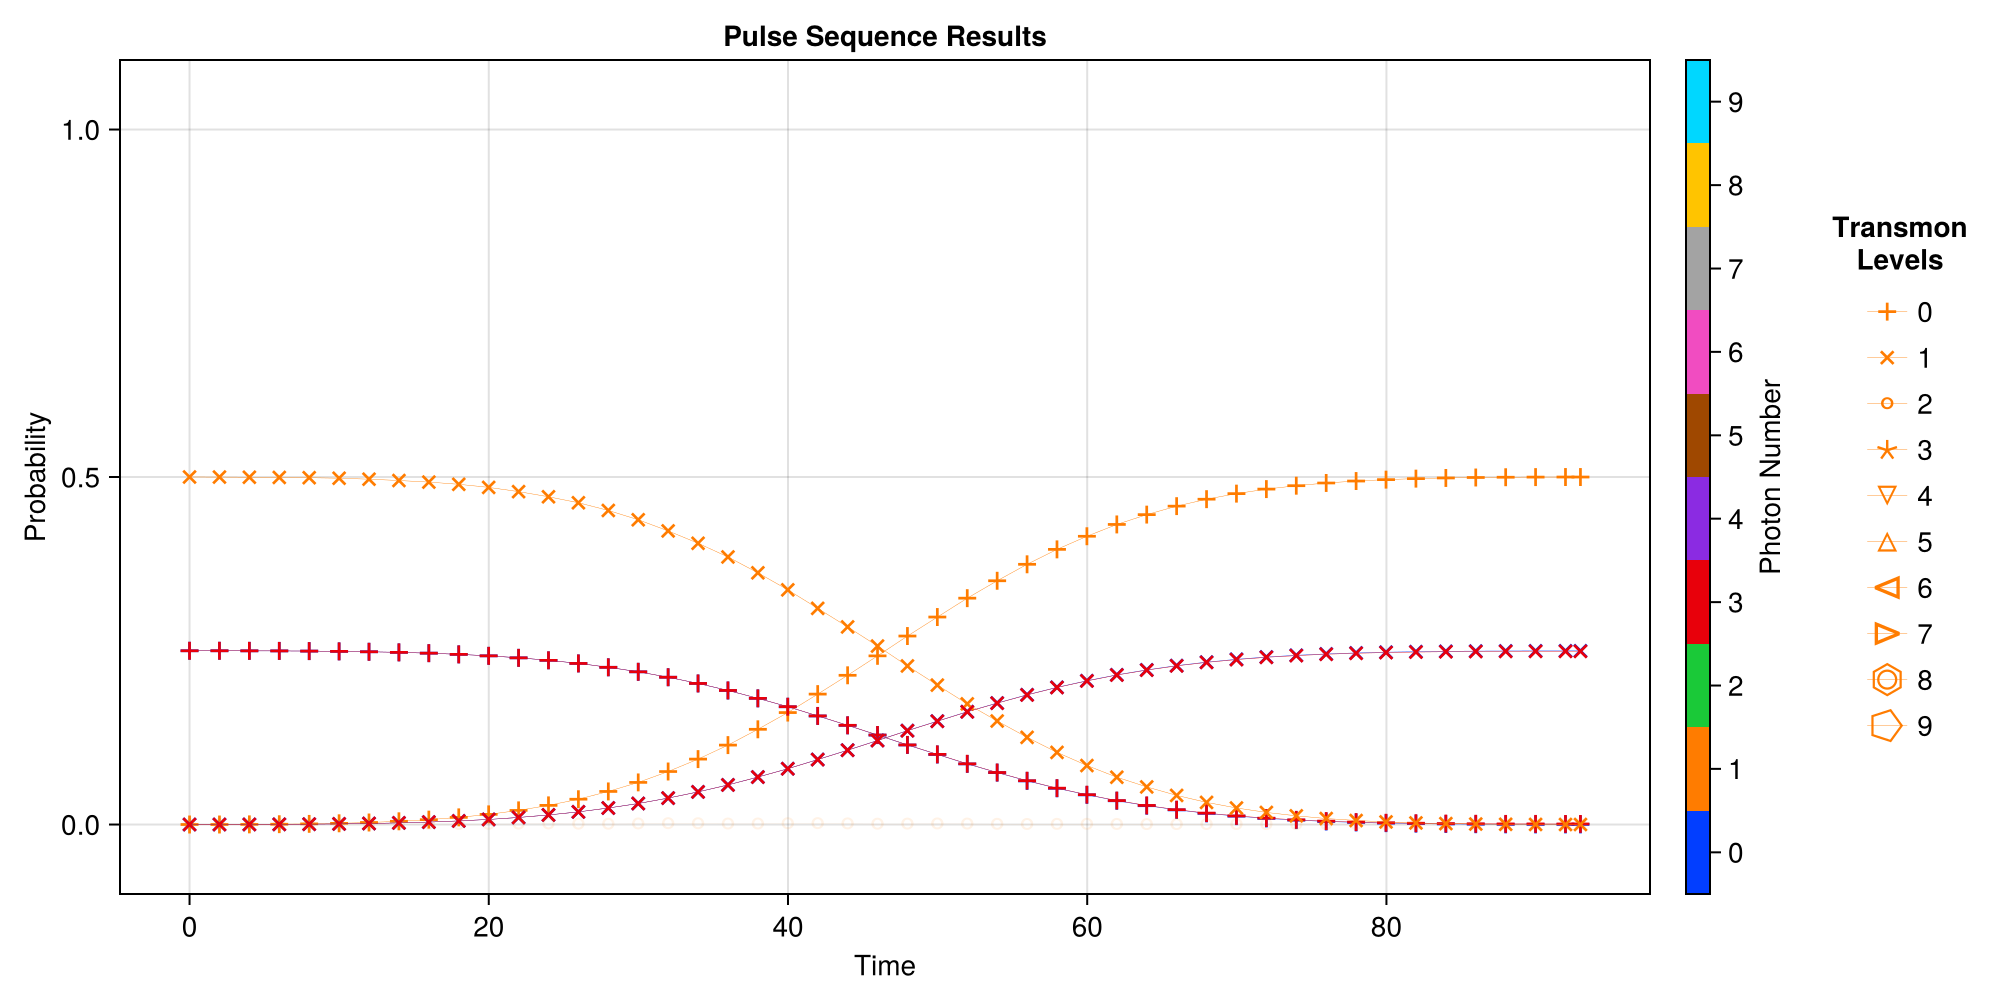

CairoMakie.Screen{IMAGE}


In [32]:
SC.Dynamics.PlotSingleModeEvolution(Mode1, q_ge_four_thirds_res["times"], EVs, plot_every = 10, emph_states = [(0,0),(1,0),(0,1),(1,1),(0,3),(1,3)])

In [33]:
println(EVs[(0,1)][end])
println(EVs[(1,0)][end])
println(EVs[(1,3)][end])

0.49994779900686603 + 4.2286399008045055e-17im
0.24989181598732335 + 3.1486120166479012e-18im
0.24915240073552183 + 3.2650777664564665e-19im


In [34]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999998089718852 + 4.587625905987619e-17im

#### $|0,2\rangle \to |1,2\rangle$

In [35]:
state1 = (0,2)
state2 = (1,2)
ψ1 = Mode1.dressed_states[state1]
ψ2 = Mode1.dressed_states[state2]

freq_d = Mode1.dressed_energies[state2]-Mode1.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge2_opt_res = SC.Dynamics.OptimizePulse(Mode1, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-08 12:22:16] Info: On Level 1
[2024-11-08 12:22:16] Info: On Step 1: t = 90.0
[2024-11-08 12:22:16] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 12:22:18] Info: Time Evolution Complete
[2024-11-08 12:22:18] Info: Done with Level_1_step_1
[2024-11-08 12:22:18] Info: Accurace: 0.997161266599651
[2024-11-08 12:22:18] Info: ------------------------------------------------------------------------------
[2024-11-08 12:22:18] Info: On Step 2: t = 92.5
[2024-11-08 12:22:18] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-08 12:22:20] Info: Time Evolution Complete
[2024-11-08 12:22:20] Info: Done with Level_1_step_2
[2024-11-08 12:22:20] Info: Accurace: 0.9996427477899547
[2024-11-08 12:22:20] Info: ------------------------------------------------------------------------------
[2024-11-08 12:22:20] Info: On S

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999712
  "freq_d"        => 4.60412

In [36]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode1.Stuff["op_drive_params"]["q_ge_2"] = deepcopy(qubit_ge2_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999712
  "freq_d"        => 4.60412

In [37]:
ψ = Mode1.dressed_states[(0, 2)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ge2_res = SC.Dynamics.RunPulseSequence(Mode1, ψ, ["q_ge_2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T12:23:06.249
It is being saved at: Data/
[2024-11-08 12:23:06] Info: Running operator q_ge_2
[2024-11-08 12:23:06] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 12:23:08] Info: Time Evolution Complete
[2024-11-08 12:23:08] Info: Saving Steps
[2024-11-08 12:23:08] Info: Done with Step_1
[2024-11-08 12:23:08] Info: Done With Running Sequence
[2024-11-08 12:23:08] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [38]:
EVs = SC.Utils.Get_EVs(q_ge2_res["states"], proj_dict);

[2024-11-08 12:23:09] Info: Making Plot


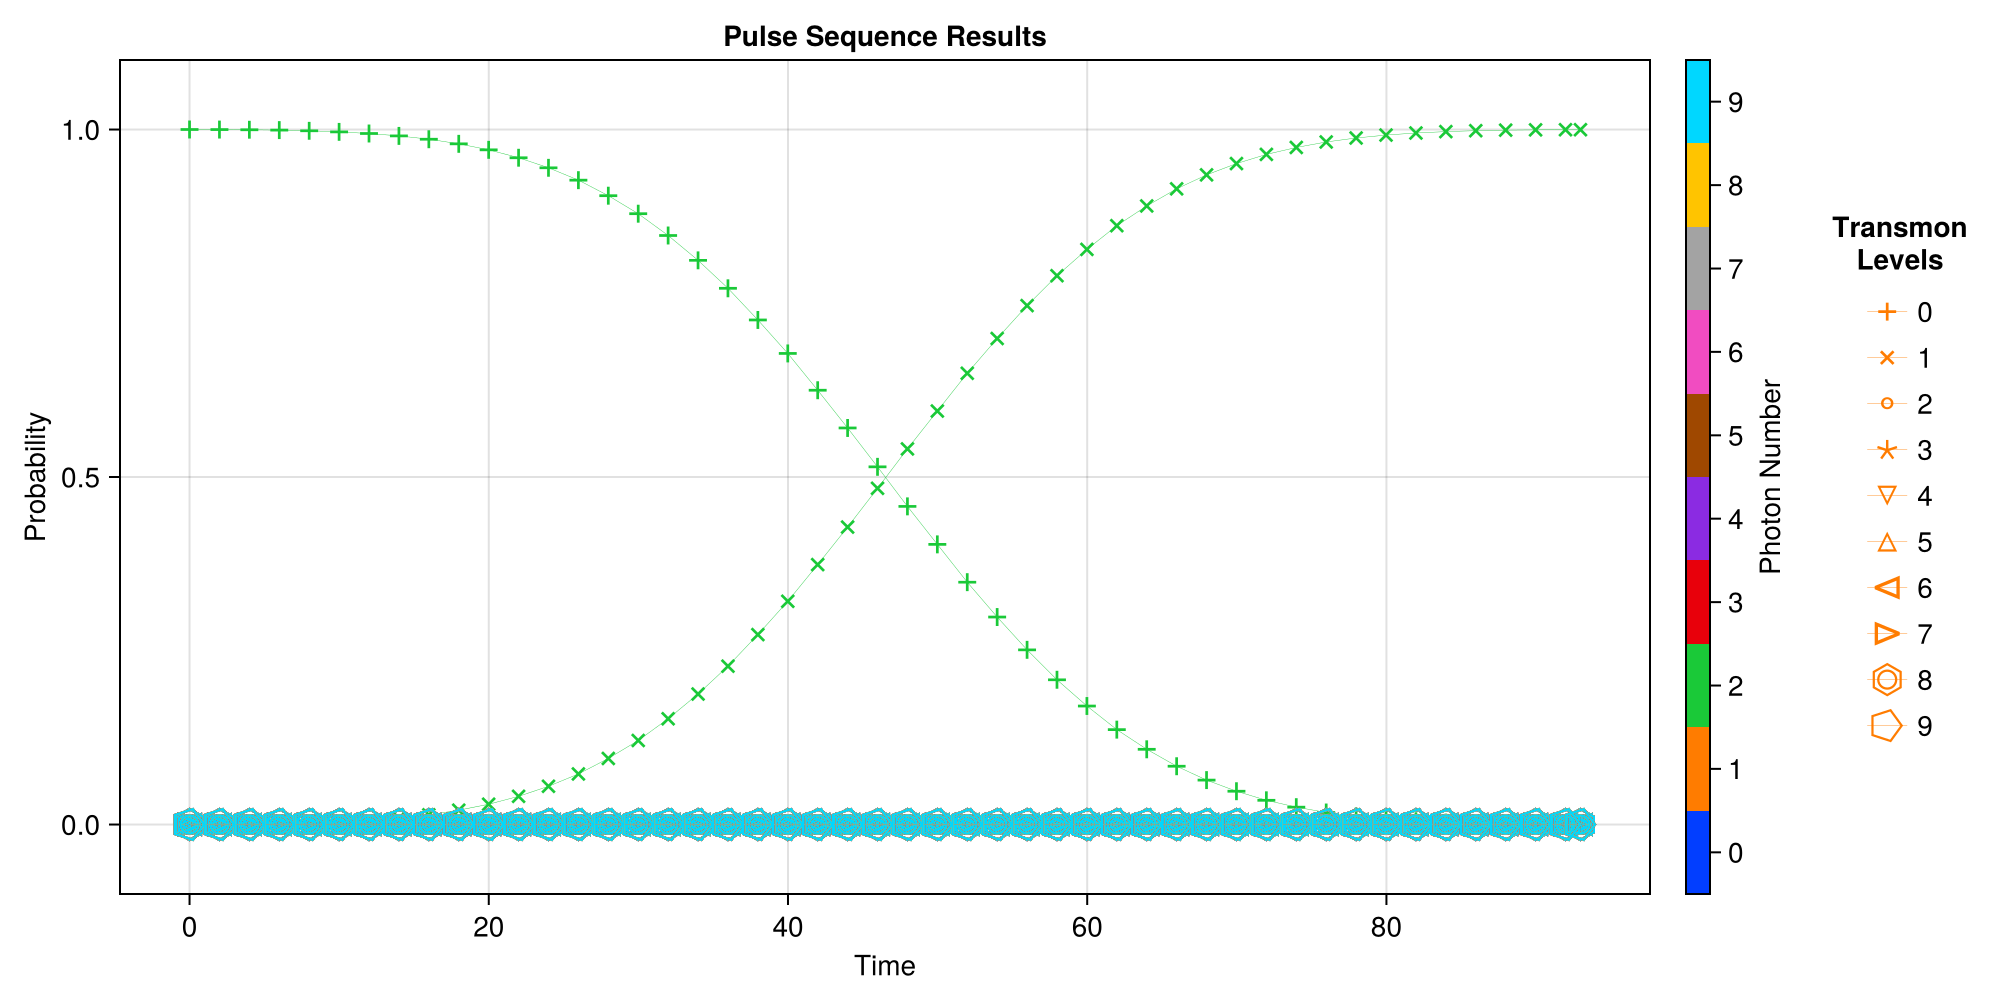

CairoMakie.Screen{IMAGE}


In [39]:
SC.Dynamics.PlotSingleModeEvolution(Mode1, q_ge2_res["times"], EVs, plot_every = 10)

In [40]:
EVs[(1,2)][end]

0.9997117640621638 - 5.59772218811603e-17im

In [41]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999988638430544 - 5.637963486106668e-17im

#### $|0,3\rangle \to |1,3\rangle$

In [42]:
state1 = (0,3)
state2 = (1,3)
ψ1 = Mode1.dressed_states[state1]
ψ2 = Mode1.dressed_states[state2]

freq_d = Mode1.dressed_energies[state2]-Mode1.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge3_opt_res = SC.Dynamics.OptimizePulse(Mode1, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-08 12:23:09] Info: On Level 1
[2024-11-08 12:23:09] Info: On Step 1: t = 90.0
[2024-11-08 12:23:09] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 12:23:11] Info: Time Evolution Complete
[2024-11-08 12:23:11] Info: Done with Level_1_step_1
[2024-11-08 12:23:11] Info: Accurace: 0.9971578663629727
[2024-11-08 12:23:11] Info: ------------------------------------------------------------------------------
[2024-11-08 12:23:11] Info: On Step 2: t = 92.5
[2024-11-08 12:23:11] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-08 12:23:13] Info: Time Evolution Complete
[2024-11-08 12:23:13] Info: Done with Level_1_step_2
[2024-11-08 12:23:13] Info: Accurace: 0.9996431119757833
[2024-11-08 12:23:13] Info: ------------------------------------------------------------------------------
[2024-11-08 12:23:13] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.60394

In [43]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode1.Stuff["op_drive_params"]["q_ge_3"] = deepcopy(qubit_ge3_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.60394

In [44]:
ψ = Mode1.dressed_states[(0, 3)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ge3_res = SC.Dynamics.RunPulseSequence(Mode1, ψ, ["q_ge_3"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T12:23:59.719
It is being saved at: Data/
[2024-11-08 12:23:59] Info: Running operator q_ge_3
[2024-11-08 12:23:59] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-08 12:24:01] Info: Time Evolution Complete
[2024-11-08 12:24:01] Info: Saving Steps
[2024-11-08 12:24:02] Info: Done with Step_1
[2024-11-08 12:24:02] Info: Done With Running Sequence
[2024-11-08 12:24:02] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [45]:
EVs = SC.Utils.Get_EVs(q_ge3_res["states"], proj_dict);

[2024-11-08 12:24:02] Info: Making Plot


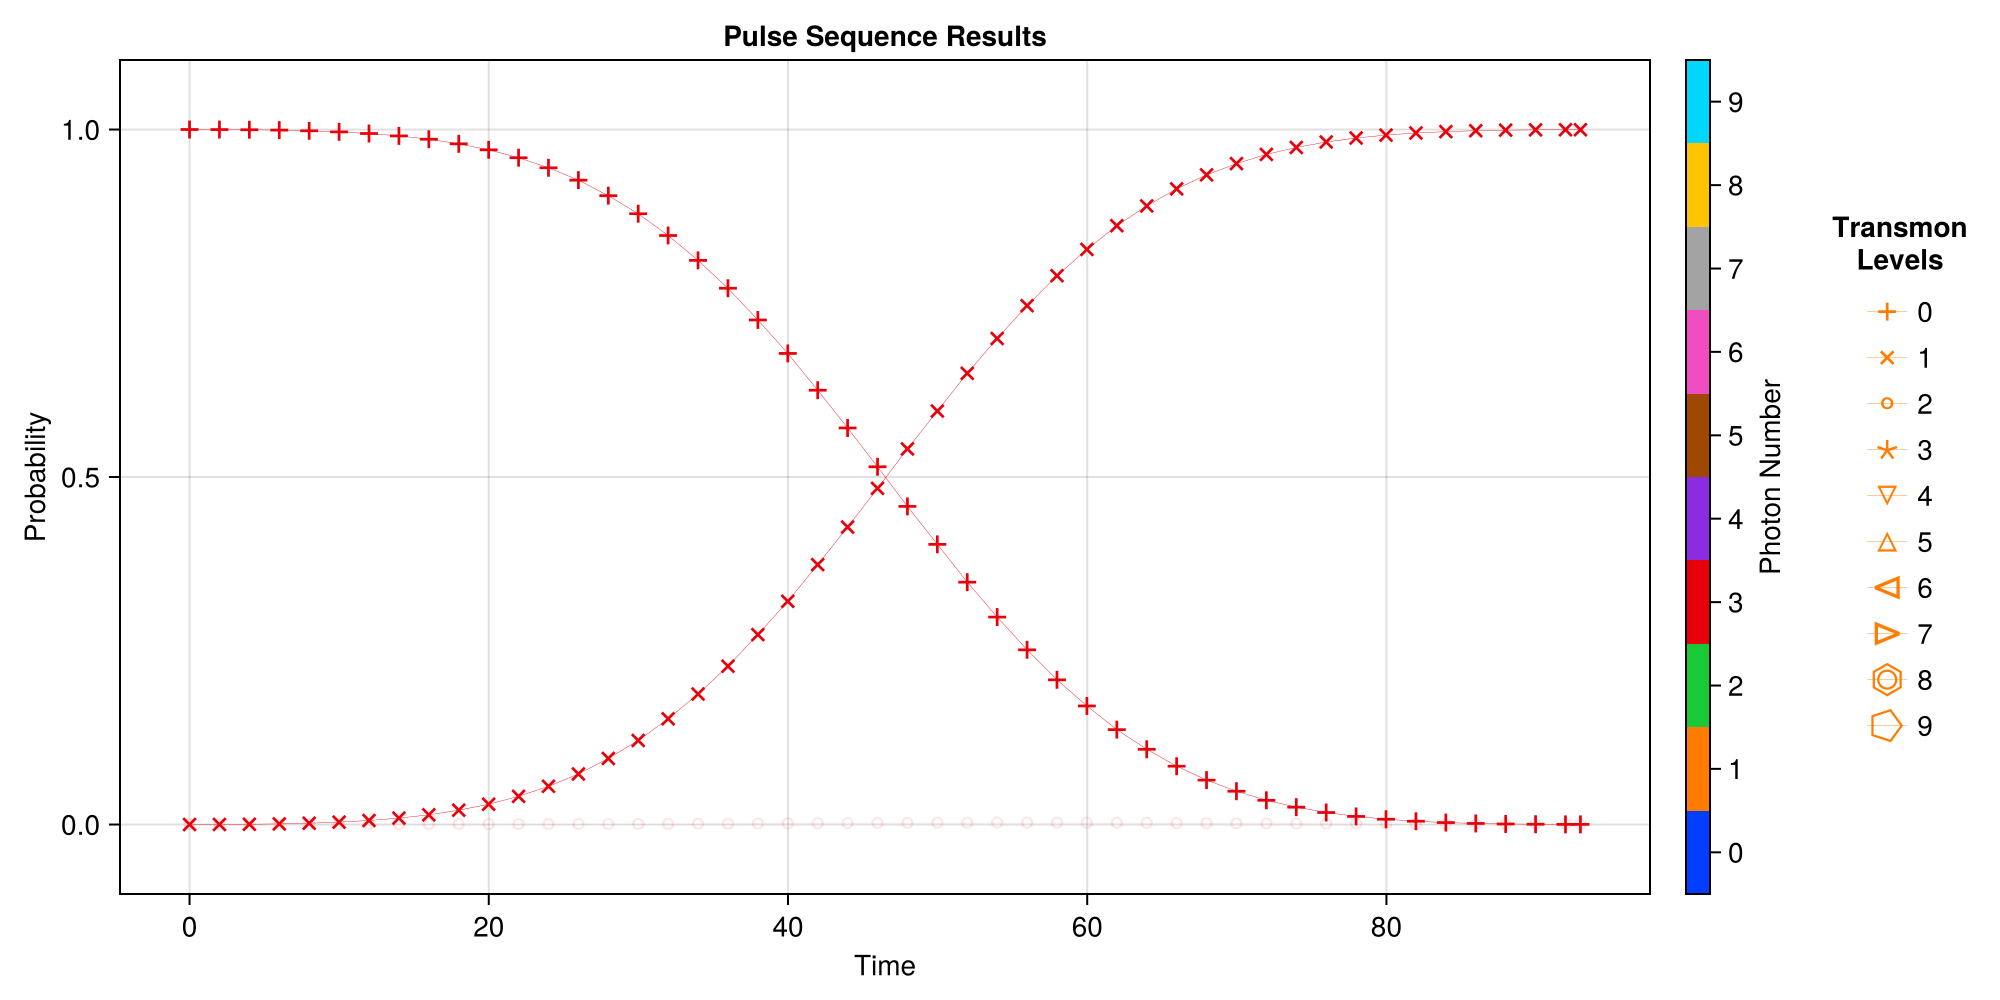

CairoMakie.Screen{IMAGE}


In [46]:
SC.Dynamics.PlotSingleModeEvolution(Mode1, q_ge3_res["times"], EVs, plot_every = 10, emph_states = [(0,3),(1,3)])

In [48]:
EVs[(1,3)][end]

0.999713154319429 + 2.572893030403419e-17im

In [49]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999999933864375 + 2.5127936485268804e-17im

### Guassian e -> f

In [50]:
println("Target σ: "*string(device_config["device"]["soc"]["qubit"]["pulses"]["pi_ef"]["sigma"]))

Target σ: 0.023251488095238096


##### Getting Stark Shift

[2024-11-08 12:24:03] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


[2024-11-08 12:24:07] Info: Done With Floquet Sweep
[2024-11-08 12:24:07] Info: Fit Stuff: 3-element Vector{Float64}:	 0.00016518812598002974	 0.008955845350145373	 2.0062812824886334
Stark shift res: [0.00016518812598002974, 55.654667567802456]


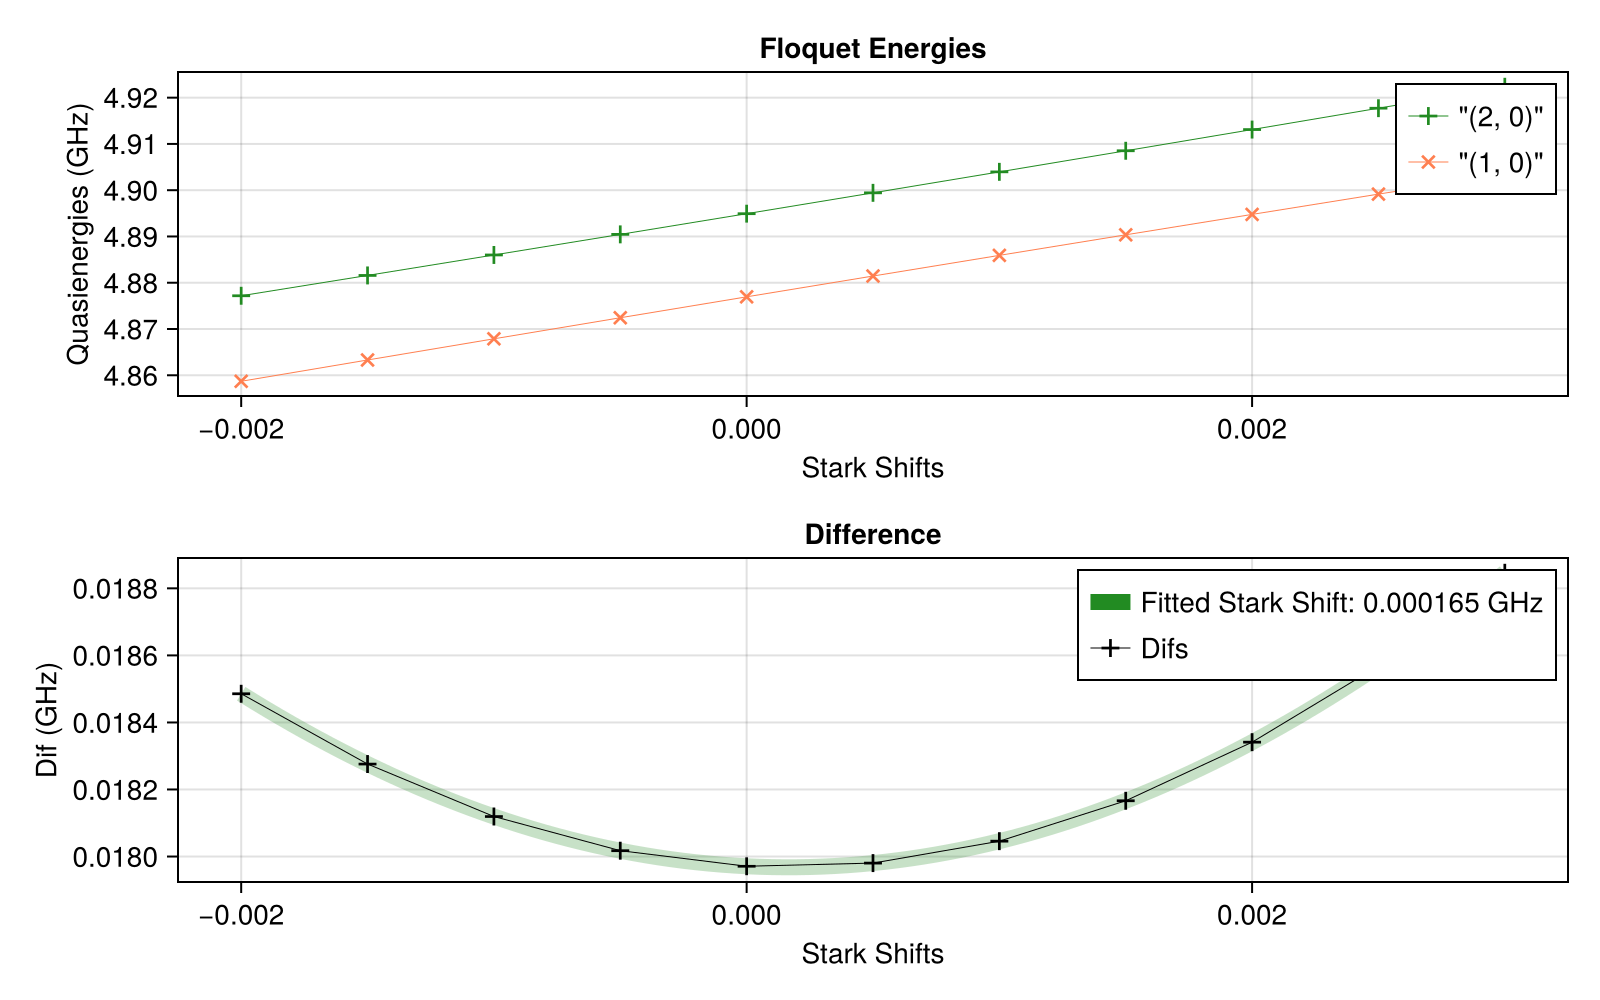

In [51]:
ef_ε = 0.00385
drive_op = Mode1.n̂ₜ
state1 = (1,0)
state2 = (2,0)

stark_shift_list = collect(LinRange(-0.002, 0.003, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode1, state1, state2, ef_ε, stark_shift_list)
println("Stark shift res: "*string(stark_shift_res))

ef_stark_shift = stark_shift_res[1];

##### $|1,0\rangle \to |2,0\rangle$

In [52]:
state1 = (1,0)
state2 = (2,0)
ψ1 = Mode1.dressed_states[state1]
ψ2 = Mode1.dressed_states[state2]

freq_d = Mode1.dressed_energies[state2]-Mode1.dressed_energies[state1] + ef_stark_shift


envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]

qubit_ef0_opt_res = SC.Dynamics.OptimizePulse(Mode1, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-08 12:24:07] Info: On Level 1
[2024-11-08 12:24:07] Info: On Step 1: t = 90.0
[2024-11-08 12:24:07] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 12:24:08] Info: Time Evolution Complete
[2024-11-08 12:24:08] Info: Done with Level_1_step_1
[2024-11-08 12:24:08] Info: Accurace: 0.9971974263251666
[2024-11-08 12:24:08] Info: ------------------------------------------------------------------------------
[2024-11-08 12:24:08] Info: On Step 2: t = 92.5
[2024-11-08 12:24:08] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 12:24:10] Info: Time Evolution Complete
[2024-11-08 12:24:10] Info: Done with Level_1_step_2
[2024-11-08 12:24:10] Info: Accurace: 0.9996771861075384
[2024-11-08 12:24:10] Info: ------------------------------------------------------------------------------
[2024-11-08 12:24:10] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999743
  "freq_d"        => 4.49604

In [53]:
#Mode1.Stuff["op_drive_params"]["q_ef_0"] = deepcopy(qubit_ef0_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode1.Stuff["op_drive_params"]["q_ef_0"] = deepcopy(qubit_ef0_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999743
  "freq_d"        => 4.49604

In [54]:
ψ = Mode1.dressed_states[(1,0)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef0_res = SC.Dynamics.RunPulseSequence(Mode1, ψ, ["q_ef_0"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T12:24:54.933
It is being saved at: Data/
[2024-11-08 12:24:54] Info: Running operator q_ef_0
[2024-11-08 12:24:54] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 12:24:56] Info: Time Evolution Complete
[2024-11-08 12:24:56] Info: Saving Steps
[2024-11-08 12:24:57] Info: Done with Step_1
[2024-11-08 12:24:57] Info: Done With Running Sequence
[2024-11-08 12:24:57] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [55]:
EVs_ef0 = SC.Utils.Get_EVs(q_ef0_res["states"], proj_dict);

[2024-11-08 12:24:57] Info: Making Plot


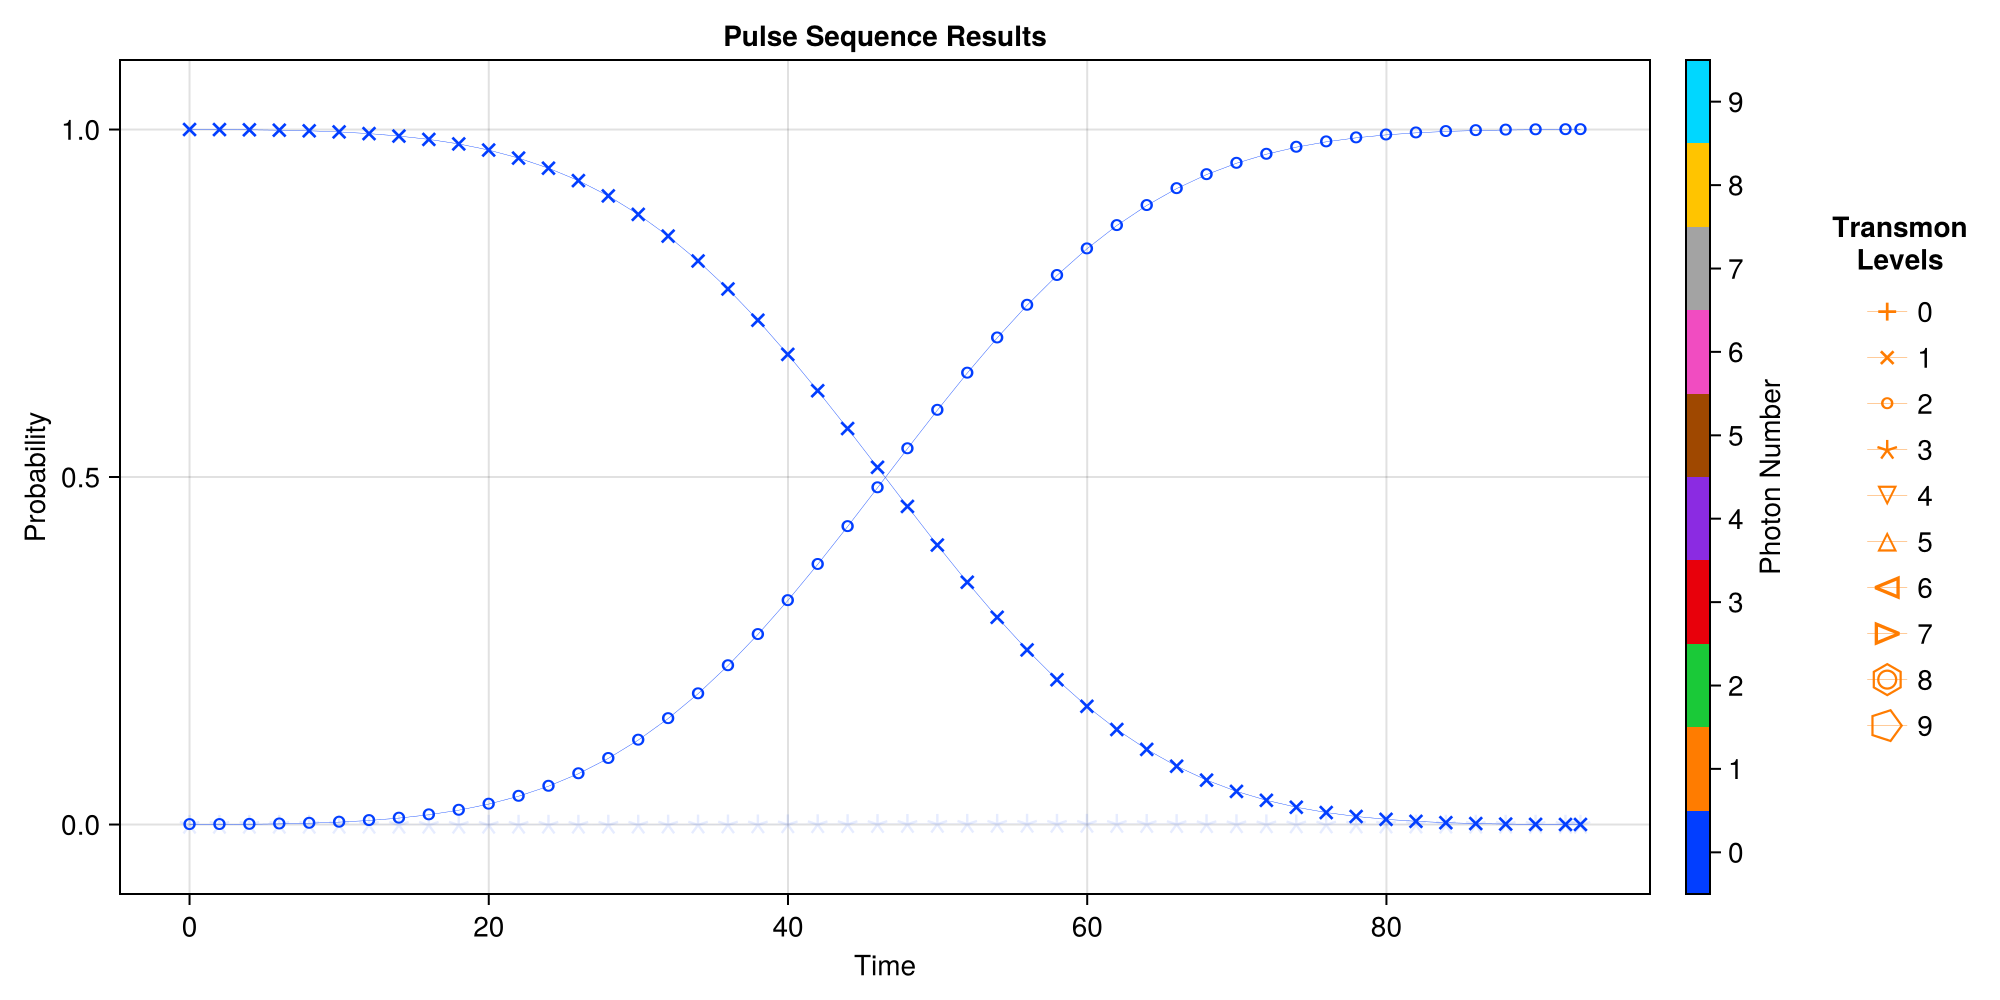

CairoMakie.Screen{IMAGE}


In [56]:
SC.Dynamics.PlotSingleModeEvolution(Mode1, q_ef0_res["times"], EVs_ef0, plot_every = 10, emph_states = [(1,0),(2,0)])

In [57]:
println(EVs_ef0[(0,0)][end])
println(EVs_ef0[(1,0)][end])
println(EVs_ef0[(2,0)][end])
println(EVs_ef0[(3,0)][end])

1.577589383905073e-5 + 2.6163636203716246e-21im
4.671852307549464e-5 + 7.838312477515545e-22im
0.9998916378214742 - 1.4592472724466314e-17im
4.315866536904173e-5 + 5.111725112223458e-21im


In [58]:
tot = 0
for key in keys(EVs_ef0)
    tot+=EVs_ef0[key][end]
end
print(tot)

0.9999972912412917 - 1.451705777620963e-17im

##### $|1,1\rangle \to |2,1\rangle$

In [59]:
state1 = (1,1)
state2 = (2,1)
ψ1 = Mode1.dressed_states[state1]
ψ2 = Mode1.dressed_states[state2]

freq_d = Mode1.dressed_energies[state2]-Mode1.dressed_energies[state1]+ef_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]

qubit_ef1_opt_res = SC.Dynamics.OptimizePulse(Mode1, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-08 12:24:57] Info: On Level 1
[2024-11-08 12:24:57] Info: On Step 1: t = 90.0
[2024-11-08 12:24:57] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 12:24:59] Info: Time Evolution Complete
[2024-11-08 12:24:59] Info: Done with Level_1_step_1
[2024-11-08 12:24:59] Info: Accurace: 0.9973394067757622
[2024-11-08 12:24:59] Info: ------------------------------------------------------------------------------
[2024-11-08 12:24:59] Info: On Step 2: t = 92.5
[2024-11-08 12:24:59] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 12:25:00] Info: Time Evolution Complete
[2024-11-08 12:25:00] Info: Done with Level_1_step_2
[2024-11-08 12:25:00] Info: Accurace: 0.9998256314156245
[2024-11-08 12:25:00] Info: ------------------------------------------------------------------------------
[2024-11-08 12:25:00] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999892
  "freq_d"        => 4.49589

In [60]:
#Mode1.Stuff["op_drive_params"]["q_ef_1"] = deepcopy(qubit_ef1_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode1.Stuff["op_drive_params"]["q_ef_1"] = deepcopy(qubit_ef1_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999892
  "freq_d"        => 4.49589

In [61]:
ψ = Mode1.dressed_states[(1,1)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef1_res = SC.Dynamics.RunPulseSequence(Mode1, ψ, ["q_ef_1"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T12:25:47.002
It is being saved at: Data/
[2024-11-08 12:25:47] Info: Running operator q_ef_1
[2024-11-08 12:25:47] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 12:25:48] Info: Time Evolution Complete
[2024-11-08 12:25:48] Info: Saving Steps
[2024-11-08 12:25:49] Info: Done with Step_1
[2024-11-08 12:25:49] Info: Done With Running Sequence
[2024-11-08 12:25:49] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [62]:
EVs = SC.Utils.Get_EVs(q_ef1_res["states"], proj_dict);

[2024-11-08 12:25:49] Info: Making Plot


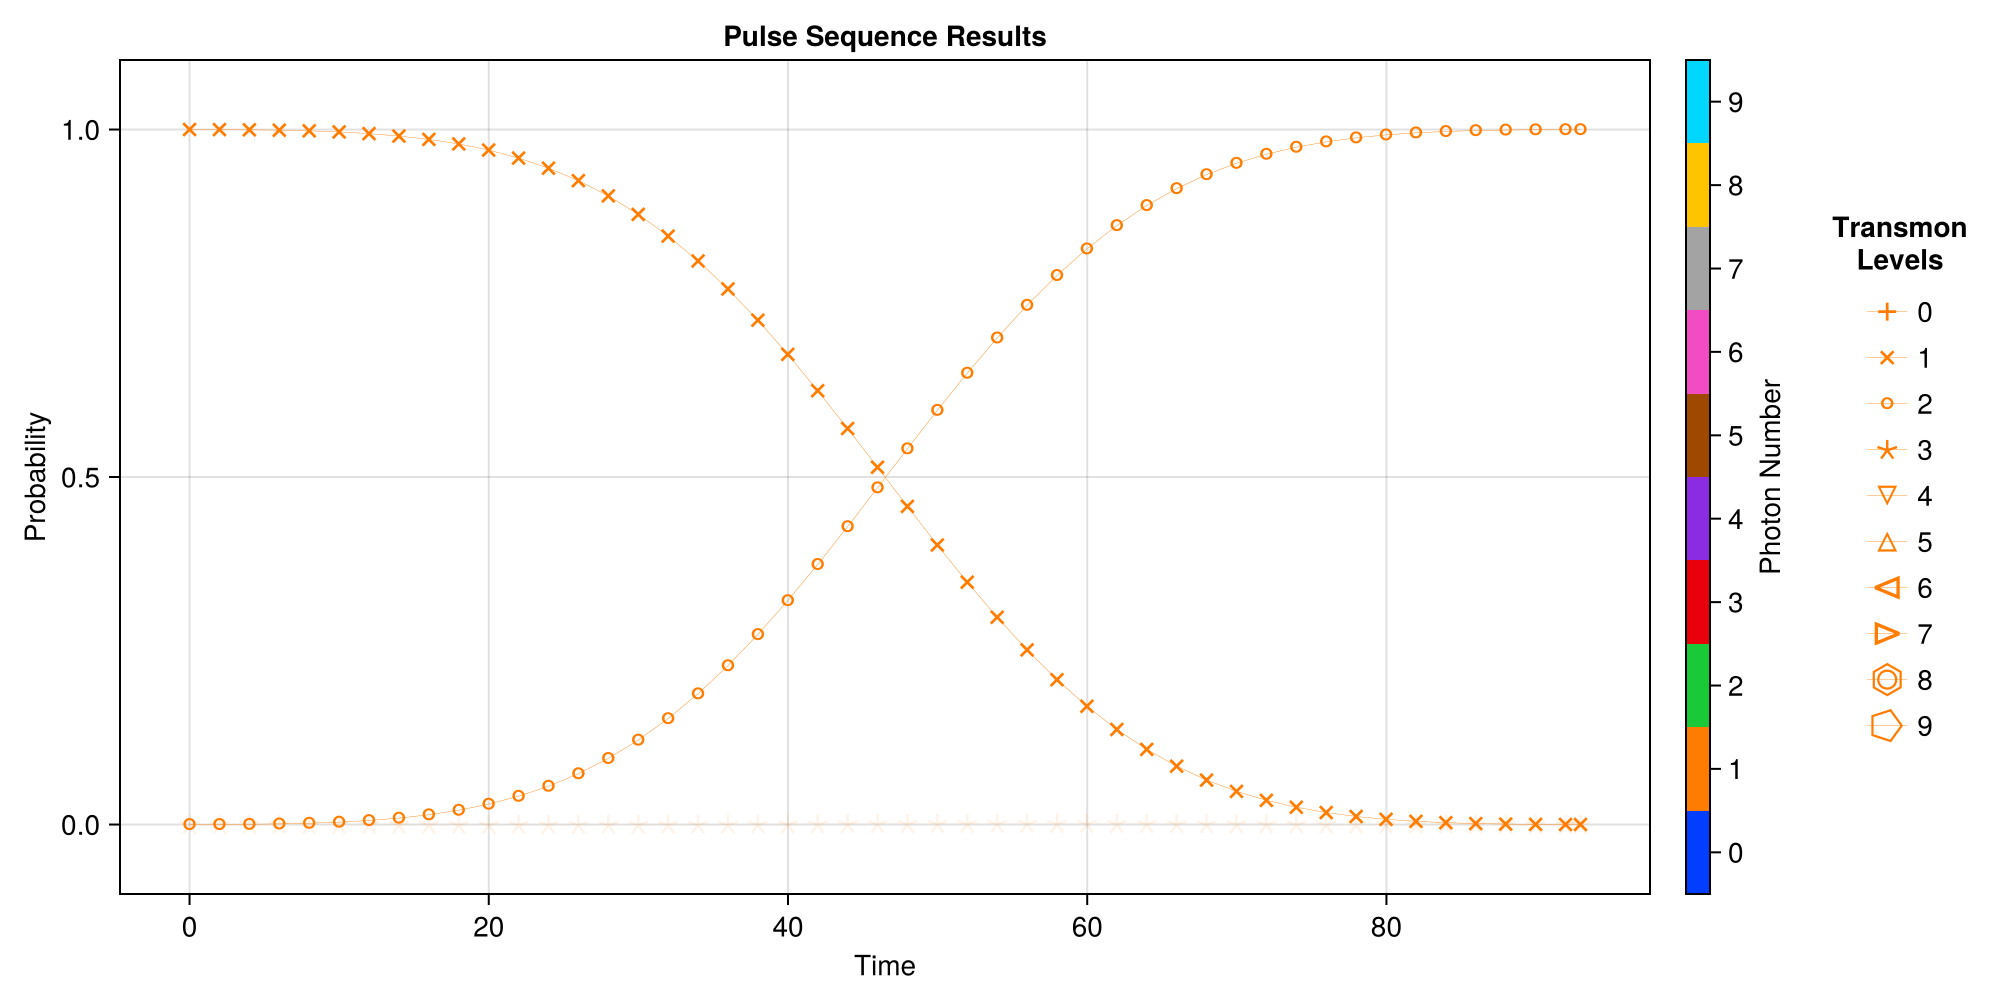

CairoMakie.Screen{IMAGE}


In [63]:
SC.Dynamics.PlotSingleModeEvolution(Mode1, q_ef1_res["times"], EVs, plot_every = 10, emph_states = [(1,1),(2,1)])

In [64]:
EVs[(2,1)][end]

0.9998929755127988 - 2.8533147230255335e-17im

In [65]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999986241349615 - 2.932681052610481e-17im

##### $|1,0\rangle+\frac{1}{\sqrt{2}}\left(|2,0\rangle + |1, 3\rangle\right)\to |2,0\rangle+\frac{1}{\sqrt{2}}\left(|1,0\rangle + |2, 3\rangle\right)$

In [66]:
ψ1 = Mode1.dressed_states[(1,0)]/sqrt(2)+Mode1.dressed_states[(2,0)]+Mode1.dressed_states[(1,3)]/sqrt(2)
ψ1 = ψ1/qt.norm(ψ1)

ψ2 = Mode1.dressed_states[(2,0)]+(Mode1.dressed_states[(1,0)]+Mode1.dressed_states[(2,3)])/sqrt(2)
ψ2 = ψ2/qt.norm(ψ2)

freq_d_ef0 = Mode1.dressed_energies[(2,0)]-Mode1.dressed_energies[(1,0)]+ef_stark_shift
freq_d_ef1 = Mode1.dressed_energies[(2,1)]-Mode1.dressed_energies[(1,1)]+ef_stark_shift
freq_d_ef3 = Mode1.dressed_energies[(2,3)]-Mode1.dressed_energies[(1,3)]+ef_stark_shift

χ = freq_d_ef1-freq_d_ef0

freq_d = freq_d_ef0+3*χ/2

check_op = proj_dict[(2,0)]+proj_dict[(1,0)]+proj_dict[(2,3)]

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ef_three_halves_opt_res = SC.Dynamics.OptimizePulse(Mode1, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5, check_op = check_op)

[2024-11-08 12:25:50] Info: On Level 1
[2024-11-08 12:25:50] Info: On Step 1: t = 90.0
[2024-11-08 12:25:50] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 12:25:52] Info: Time Evolution Complete
[2024-11-08 12:25:52] Info: Done with Level_1_step_1
[2024-11-08 12:25:52] Info: Accurace: 0.9989605208924164
[2024-11-08 12:25:52] Info: ------------------------------------------------------------------------------
[2024-11-08 12:25:52] Info: On Step 2: t = 92.5
[2024-11-08 12:25:52] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-08 12:25:54] Info: Time Evolution Complete
[2024-11-08 12:25:54] Info: Done with Level_1_step_2
[2024-11-08 12:25:54] Info: Accurace: 0.9994992481055941
[2024-11-08 12:25:54] Info: ------------------------------------------------------------------------------
[2024-11-08 12:25:54] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999509
  "freq_d"        => 4.49581

In [67]:
#Mode1.Stuff["op_drive_params"]["q_ef_3/2"] = deepcopy(qubit_ef_three_halves_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode1.Stuff["op_drive_params"]["q_ef_3/2"] = deepcopy(qubit_ef_three_halves_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999509
  "freq_d"        => 4.49581

In [68]:
ψ = Mode1.dressed_states[(1,0)]/sqrt(2)+Mode1.dressed_states[(2,0)]+Mode1.dressed_states[(1,3)]/sqrt(2)
ψ = ψ/qt.norm(ψ)
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ef_three_halves_res = SC.Dynamics.RunPulseSequence(Mode1, ψ, ["q_ef_3/2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T12:26:40.027
It is being saved at: Data/
[2024-11-08 12:26:40] Info: Running operator q_ef_3/2
[2024-11-08 12:26:40] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-08 12:26:43] Info: Time Evolution Complete
[2024-11-08 12:26:43] Info: Saving Steps
[2024-11-08 12:26:43] Info: Done with Step_1
[2024-11-08 12:26:43] Info: Done With Running Sequence
[2024-11-08 12:26:43] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [69]:
EVs = SC.Utils.Get_EVs(q_ef_three_halves_res["states"], proj_dict);

[2024-11-08 12:26:44] Info: Making Plot


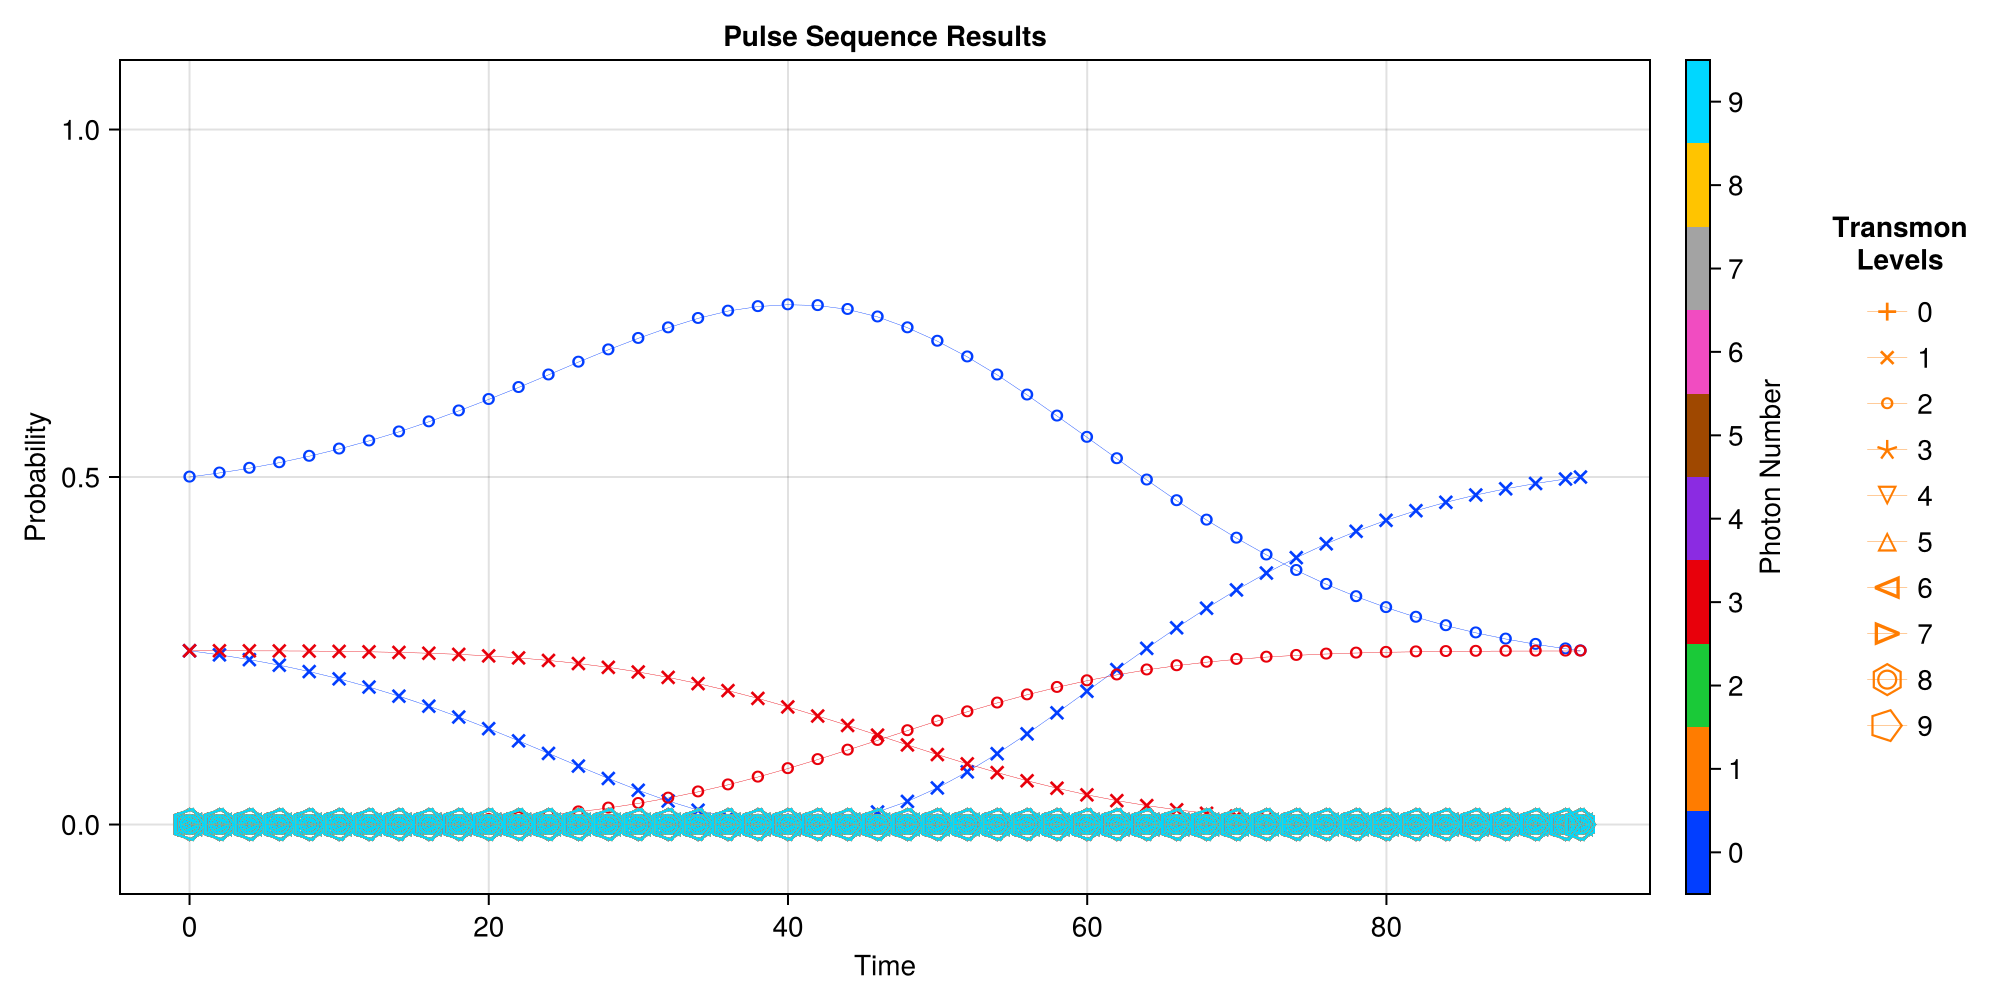

CairoMakie.Screen{IMAGE}


In [70]:
SC.Dynamics.PlotSingleModeEvolution(Mode1, q_ef_three_halves_res["times"], EVs, plot_every = 10)

In [71]:
println(EVs[(2,0)][end])
println(EVs[(1,0)][end])
println(EVs[(2,3)][end])

0.24996957419591292 - 9.654662823421895e-18im
0.49994702652727946 + 6.40249771043959e-18im
0.24962749352010927 - 1.8536628985211314e-17im


In [72]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999998246248601 - 2.1605285945294808e-17im

##### $|1,2\rangle \to |2,2\rangle$

In [73]:
state1 = (1,2)
state2 = (2,2)
ψ1 = Mode1.dressed_states[state1]
ψ2 = Mode1.dressed_states[state2]

freq_d = Mode1.dressed_energies[state2]-Mode1.dressed_energies[state1]+ef_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]

qubit_ef2_opt_res = SC.Dynamics.OptimizePulse(Mode1, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 7)


[2024-11-08 12:26:44] Info: On Level 1
[2024-11-08 12:26:44] Info: On Step 1: t = 90.0
[2024-11-08 12:26:44] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 12:26:46] Info: Time Evolution Complete
[2024-11-08 12:26:46] Info: Done with Level_1_step_1
[2024-11-08 12:26:46] Info: Accurace: 0.9973371031285408
[2024-11-08 12:26:46] Info: ------------------------------------------------------------------------------
[2024-11-08 12:26:46] Info: On Step 2: t = 92.5
[2024-11-08 12:26:46] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-08 12:26:48] Info: Time Evolution Complete
[2024-11-08 12:26:48] Info: Done with Level_1_step_2
[2024-11-08 12:26:48] Info: Accurace: 0.9998269391335513
[2024-11-08 12:26:48] Info: ------------------------------------------------------------------------------
[2024-11-08 12:26:48] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 93.0078
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.252, "mu"=>46.5039)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999894
  "freq_d"        => 4.49574

In [74]:
#Mode1.Stuff["op_drive_params"]["q_ef_2"] = deepcopy(qubit_ef2_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode1.Stuff["op_drive_params"]["q_ef_2"] = deepcopy(qubit_ef2_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 93.0078
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.252, "mu"=>46.5039)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999894
  "freq_d"        => 4.49574

In [75]:
ψ = Mode1.dressed_states[(1,2)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef2_res = SC.Dynamics.RunPulseSequence(Mode1, ψ, ["q_ef_2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T12:27:52.957
It is being saved at: Data/
[2024-11-08 12:27:52] Info: Running operator q_ef_2
[2024-11-08 12:27:52] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-08 12:27:55] Info: Time Evolution Complete
[2024-11-08 12:27:55] Info: Saving Steps
[2024-11-08 12:27:55] Info: Done with Step_1
[2024-11-08 12:27:55] Info: Done With Running Sequence
[2024-11-08 12:27:55] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199588, 0.399175, 0.598763, 0.79835, 0.997938, 1.19753…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [76]:
EVs = SC.Utils.Get_EVs(q_ef2_res["states"], proj_dict);

[2024-11-08 12:27:55] Info: Making Plot


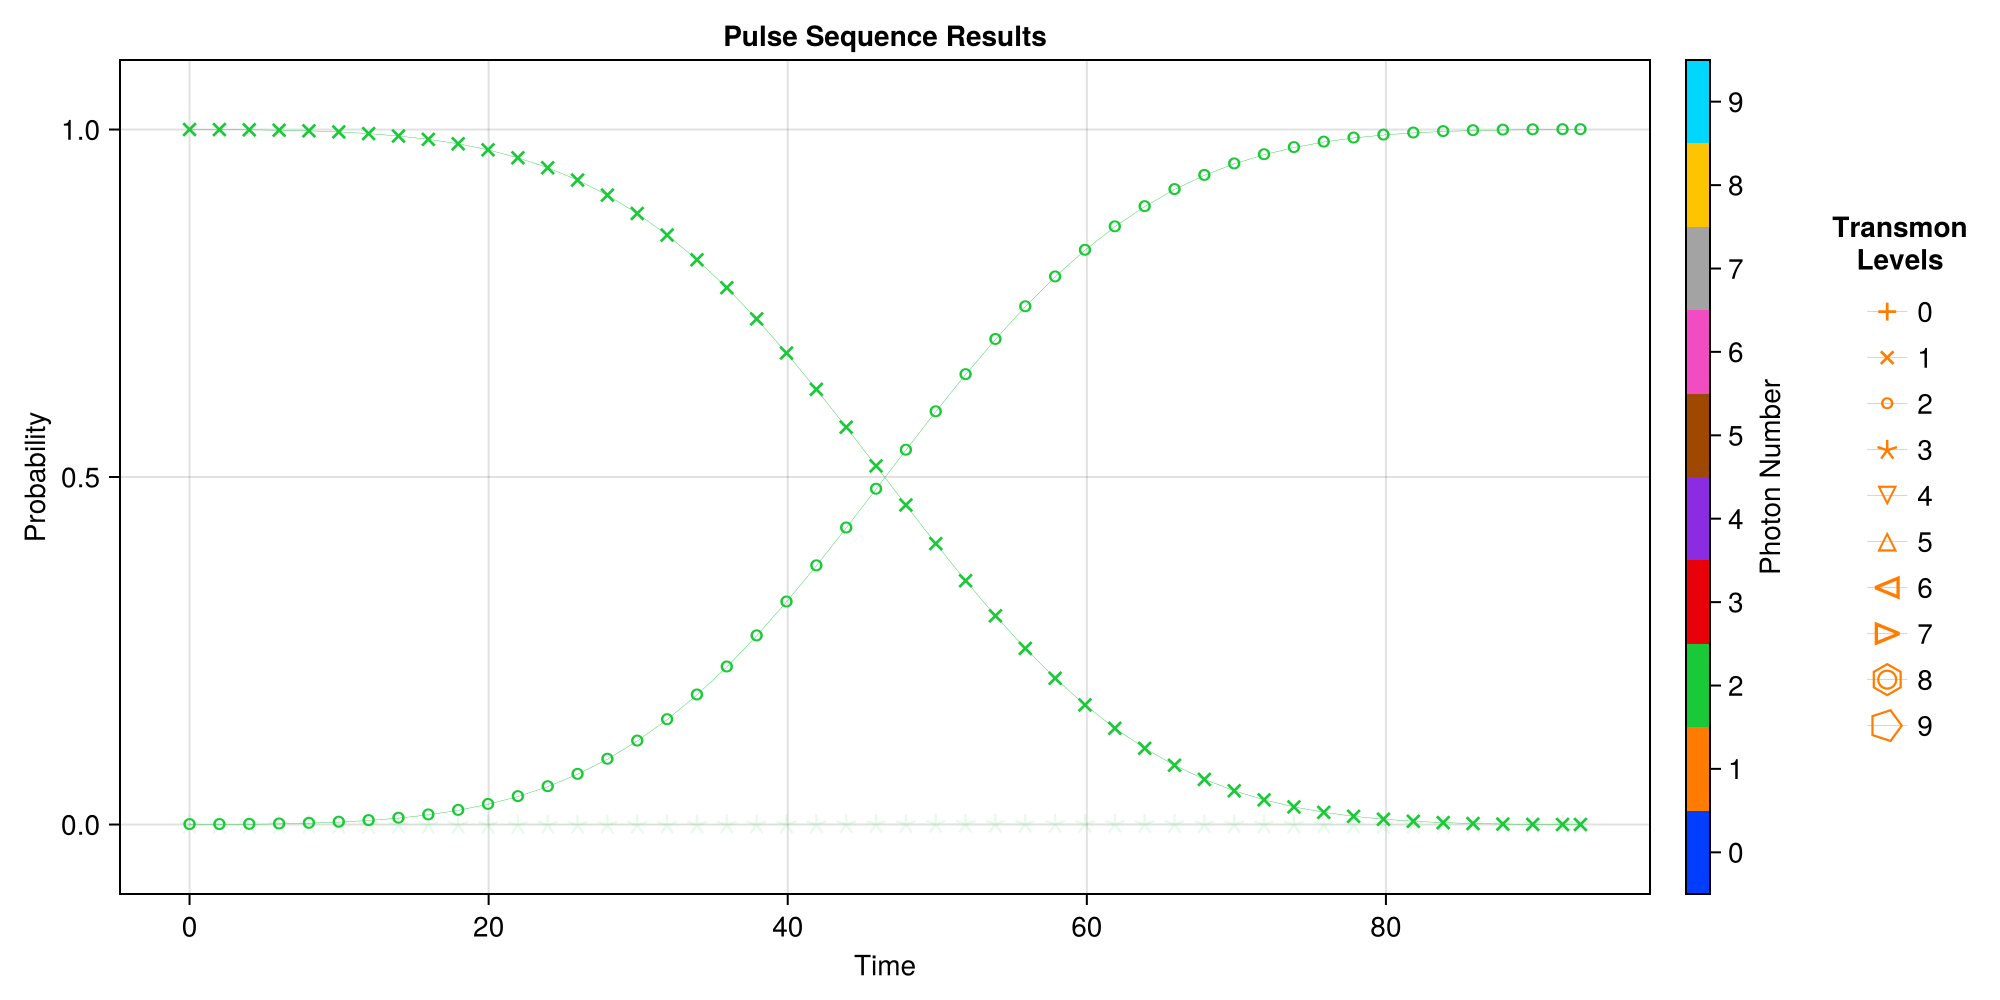

CairoMakie.Screen{IMAGE}


In [77]:
SC.Dynamics.PlotSingleModeEvolution(Mode1, q_ef2_res["times"], EVs, plot_every = 10, emph_states = [(1,2),(2,2)])

In [78]:
EVs[(2,2)][end]

0.9998943970231 - 6.66155041574166e-18im

In [79]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999999869440059 - 6.977697080406102e-18im

##### $|1,3\rangle \to |2,3\rangle$

In [80]:
state1 = (1,3)
state2 = (2,3)
ψ1 = Mode1.dressed_states[state1]
ψ2 = Mode1.dressed_states[state2]

freq_d = Mode1.dressed_energies[state2]-Mode1.dressed_energies[state1]+ef_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 110]

qubit_ef3_opt_res = SC.Dynamics.OptimizePulse(Mode1, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-08 12:27:56] Info: On Level 1
[2024-11-08 12:27:56] Info: On Step 1: t = 90.0
[2024-11-08 12:27:56] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 12:27:57] Info: Time Evolution Complete
[2024-11-08 12:27:57] Info: Done with Level_1_step_1
[2024-11-08 12:27:57] Info: Accurace: 0.9973330740910272
[2024-11-08 12:27:57] Info: ------------------------------------------------------------------------------
[2024-11-08 12:27:57] Info: On Step 2: t = 95.0
[2024-11-08 12:27:57] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 12:27:59] Info: Time Evolution Complete
[2024-11-08 12:27:59] Info: Done with Level_1_step_2
[2024-11-08 12:27:59] Info: Accurace: 0.9987499614601845
[2024-11-08 12:27:59] Info: ------------------------------------------------------------------------------
[2024-11-08 12:27:59] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 93.125
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2812, "mu"=>46.5625)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.99989
  "freq_d"        => 4.49559

In [81]:
#Mode1.Stuff["op_drive_params"]["q_ef_3"] = deepcopy(qubit_ef3_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode1.Stuff["op_drive_params"]["q_ef_3"] = deepcopy(qubit_ef3_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 93.125
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2812, "mu"=>46.5625)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.99989
  "freq_d"        => 4.49559

In [82]:
ψ = Mode1.dressed_states[(1,3)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef3_res = SC.Dynamics.RunPulseSequence(Mode1, ψ, ["q_ef_3"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T12:28:44.606
It is being saved at: Data/
[2024-11-08 12:28:44] Info: Running operator q_ef_3
[2024-11-08 12:28:44] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 12:28:46] Info: Time Evolution Complete
[2024-11-08 12:28:46] Info: Saving Steps
[2024-11-08 12:28:47] Info: Done with Step_1
[2024-11-08 12:28:47] Info: Done With Running Sequence
[2024-11-08 12:28:47] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199839, 0.399678, 0.599517, 0.799356, 0.999195, 1.1990…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [83]:
EVs = SC.Utils.Get_EVs(q_ef3_res["states"], proj_dict);

[2024-11-08 12:28:47] Info: Making Plot


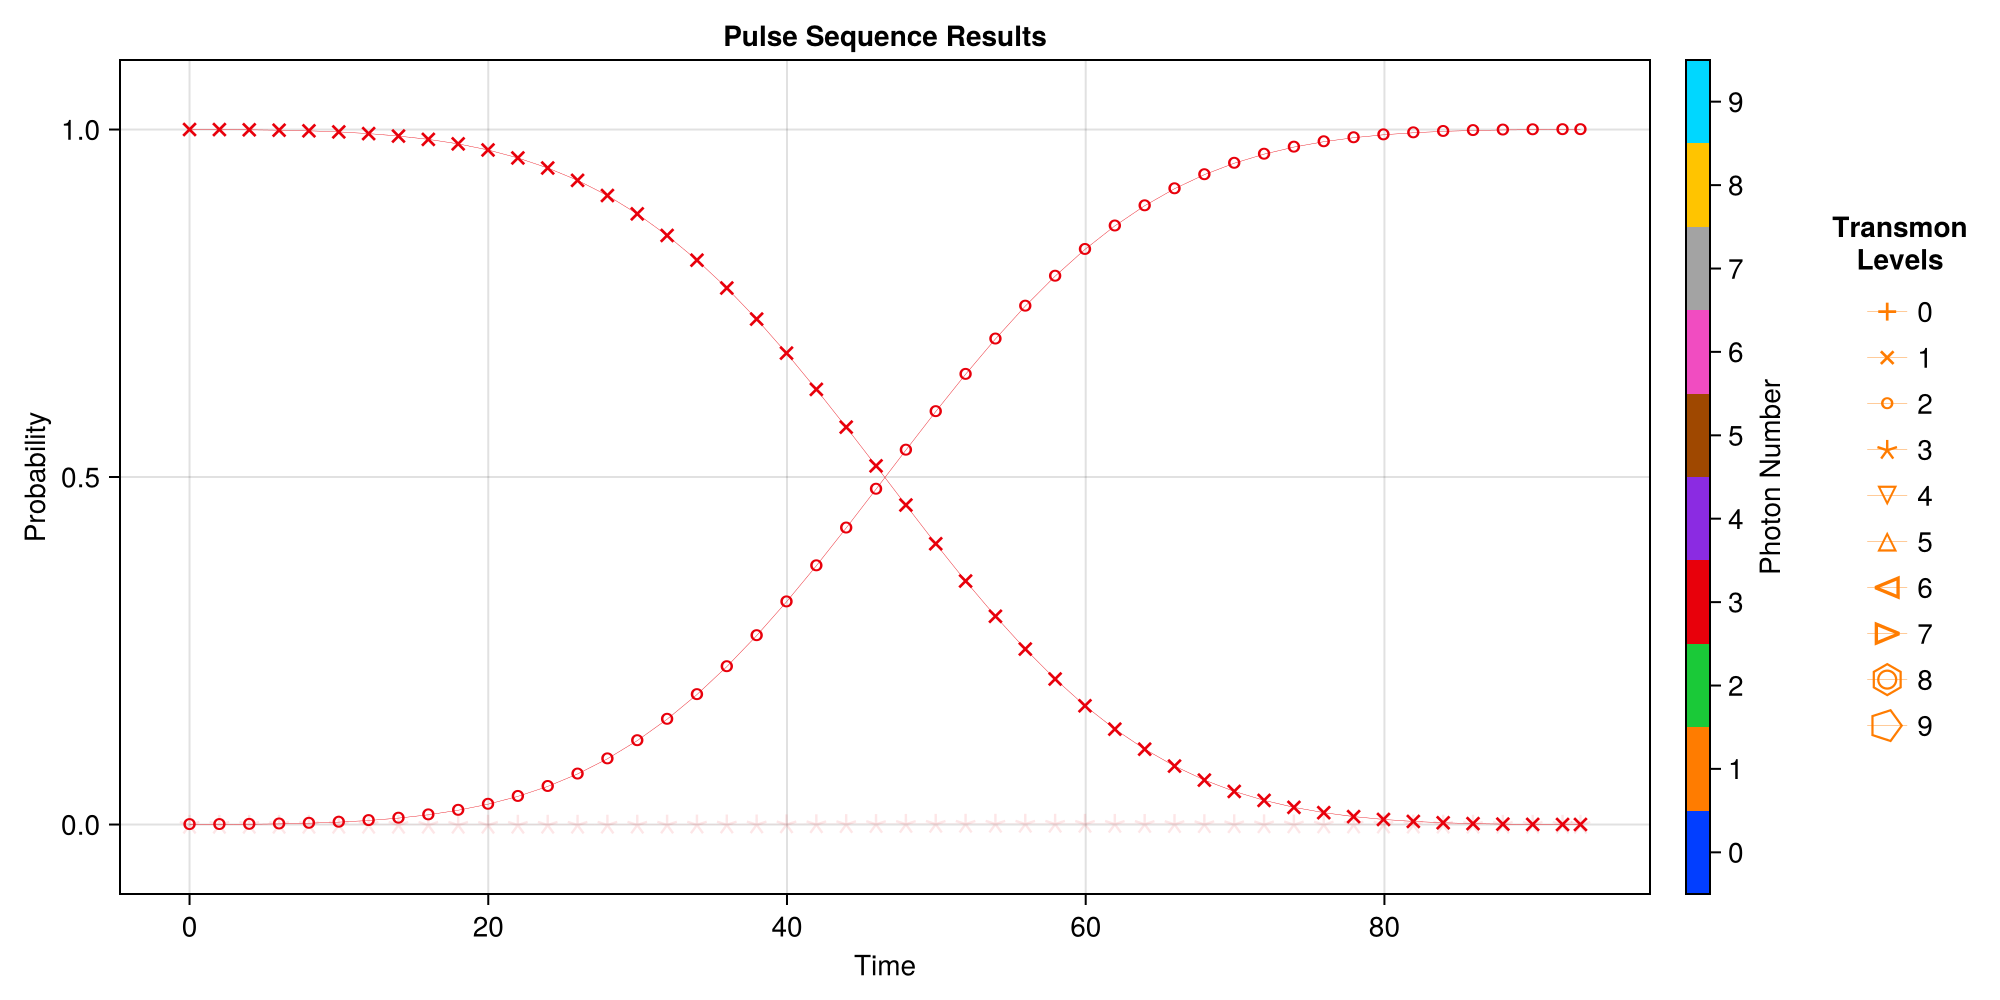

CairoMakie.Screen{IMAGE}


In [84]:
SC.Dynamics.PlotSingleModeEvolution(Mode1, q_ef3_res["times"], EVs, plot_every = 10, emph_states = [(1,3),(2,3)])

In [85]:
EVs[(2, 3)][end]

0.9998898258970271 - 2.858616561980357e-16im

In [86]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
tot

0.9999999998563234 - 2.8744137705847814e-16im

### Half Qubit $|g0\rangle \to |g0\rangle+|e0\rangle$

In [87]:
starting_args = deepcopy(Mode1.Stuff["op_drive_params"]["q_ge_0"])

envelope_args = starting_args["Envelope Args"]
envelope = starting_args["Envelope"]
freq_d = starting_args["freq_d"]
stark_shift = starting_args["shift"]
ε = starting_args["epsilon"]*0.5

ψ1 = Mode1.dressed_states[(0,0)]
ψ2 = Mode1.dressed_states[(0,0)] + Mode1.dressed_states[(1,0)]
ψ2 = ψ2/sqrt(2)

op = Mode1.dressed_states[(0,0)]*Mode1.dressed_states[(1,0)]'*2



t_range = [starting_args["pulse_time"], starting_args["pulse_time"]]


optimize_res_half_g0e0 = SC.Dynamics.OptimizePulse(Mode1, ψ1, ψ2, ε, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 1, check_op = op)

[2024-11-08 12:28:48] Info: On Level 1
[2024-11-08 12:28:48] Info: On Step 1: t = 92.96875
[2024-11-08 12:28:48] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-08 12:28:50] Info: Time Evolution Complete
[2024-11-08 12:28:50] Info: Done with Level_1_step_1
[2024-11-08 12:28:50] Info: Accurace: 0.9995566945913934
[2024-11-08 12:28:50] Info: ------------------------------------------------------------------------------
[2024-11-08 12:28:50] Info: Highest Accuracy: 0.9995566945913934
[2024-11-08 12:28:50] Info: New ti: 92.96875, new tf: 92.96875
[2024-11-08 12:28:50] Info: ===================================================================================================	


Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00269
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999557
  "freq_d"        => 4.60449

In [88]:
#Mode1.Stuff["op_drive_params"]["q_half_ge0"] = deepcopy(optimize_res_half_g0e0)
if GLOBAL_SAVE_CALIBRATE | false
    Mode1.Stuff["op_drive_params"]["q_half_ge0"] = deepcopy(optimize_res_half_g0e0)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00269
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999557
  "freq_d"        => 4.60449

In [89]:
ψ = Mode1.dressed_states[(0,0)]
res_half_ge0 = SC.Dynamics.RunPulseSequence(Mode1, ψ, ["q_half_ge0"], Return = true, clean_up = true)

The Name for this run is: Operator_Sequence_2024-11-08T12:28:50.323
It is being saved at: Data/
[2024-11-08 12:28:50] Info: Running operator q_half_ge0
[2024-11-08 12:28:50] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 12:28:52] Info: Time Evolution Complete
[2024-11-08 12:28:52] Info: Saving Steps
[2024-11-08 12:28:52] Info: Done with Step_1
[2024-11-08 12:28:52] Info: Done With Running Sequence
[2024-11-08 12:28:52] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [90]:
EVs_Dict = SC.Utils.Get_EVs(res_half_ge0["states"], proj_dict);

[2024-11-08 12:28:53] Info: Making Plot


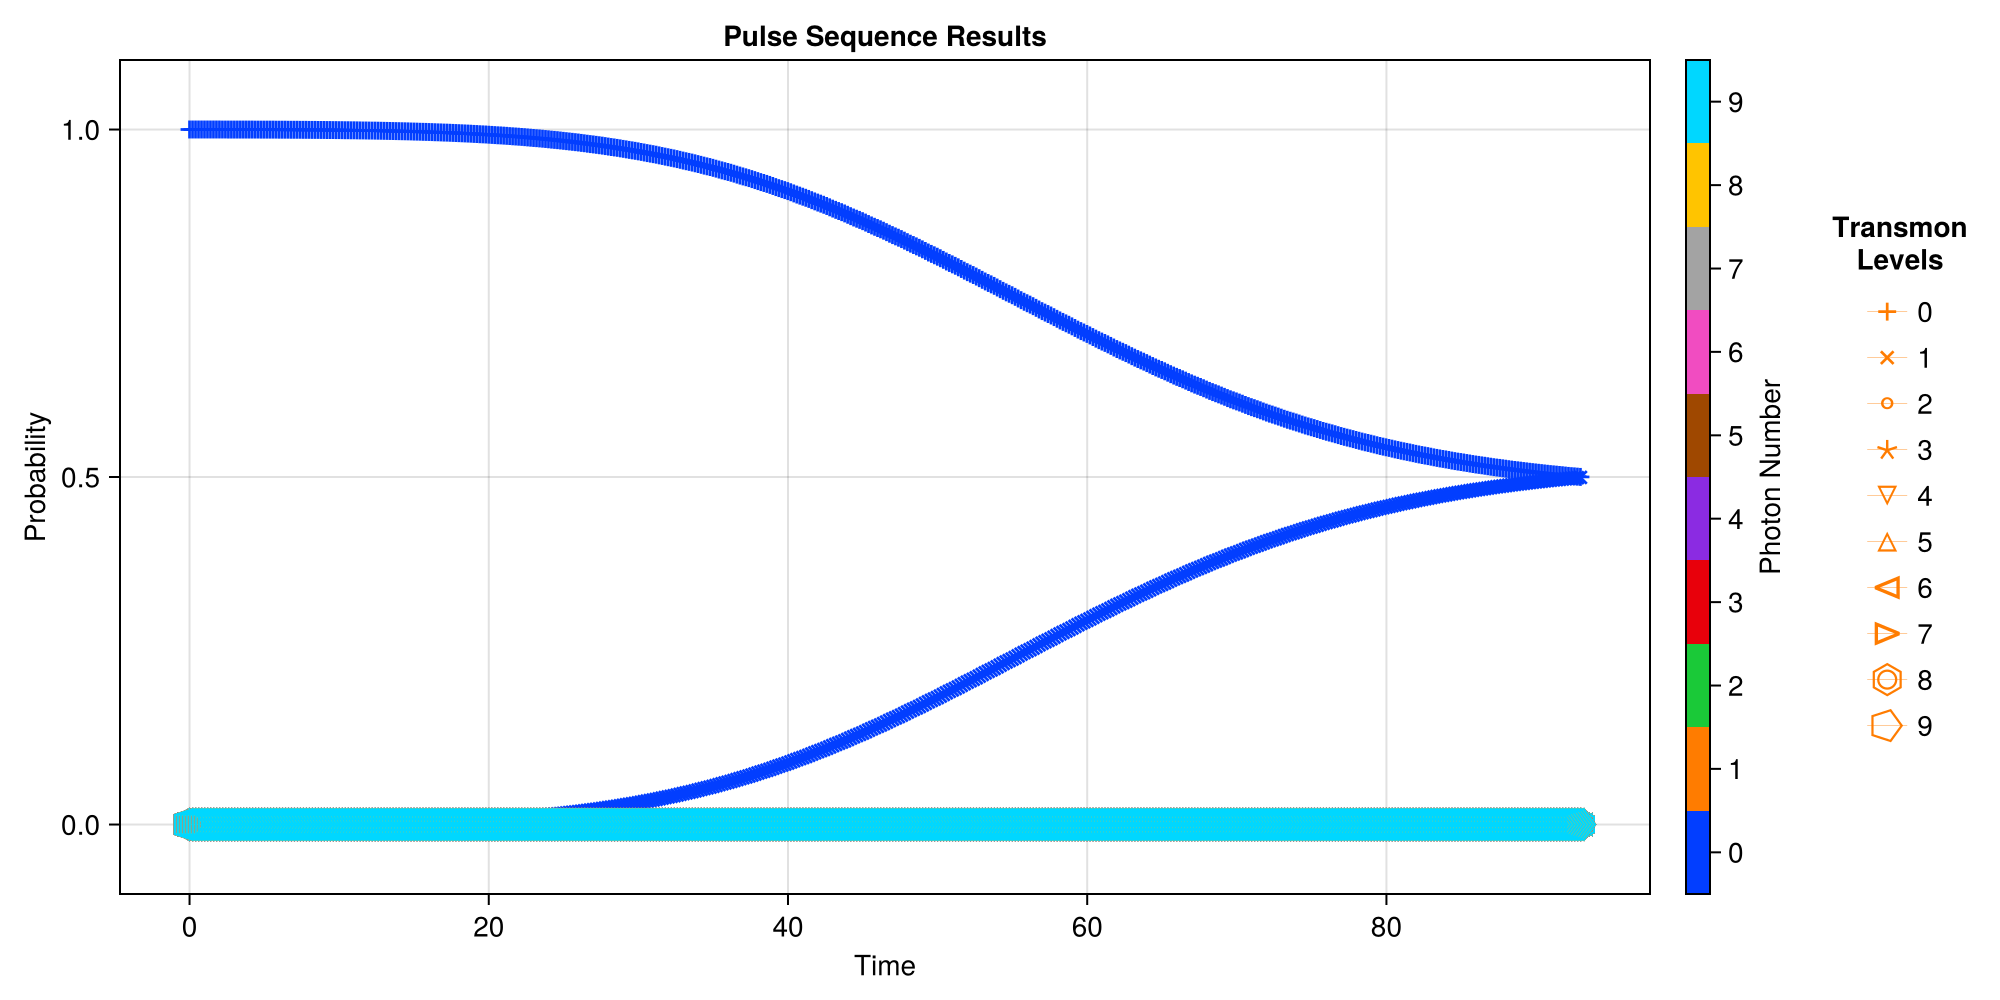

In [91]:
SC.Dynamics.PlotSingleModeEvolution(Mode1, res_half_ge0["times"], EVs_Dict);

In [92]:
println(EVs_Dict[(0,0)][end])
println(EVs_Dict[(1,0)][end])

0.5001246074457136 + 7.566262925432723e-17im
0.49943232687811734 + 1.5432952325712104e-18im


## Sidebands at $\varepsilon = 0.295$

### Getting Stark Shift

[2024-11-08 13:19:21] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


[2024-11-08 13:19:34] Info: Done With Floquet Sweep
[2024-11-08 13:19:35] Info: Fit Stuff: 3-element Vector{Float64}:	 0.01524592951607475	 0.0014930227269433906	 2.062028416049746
Stark shift res: [0.01524592951607475, 324.81713806973005]


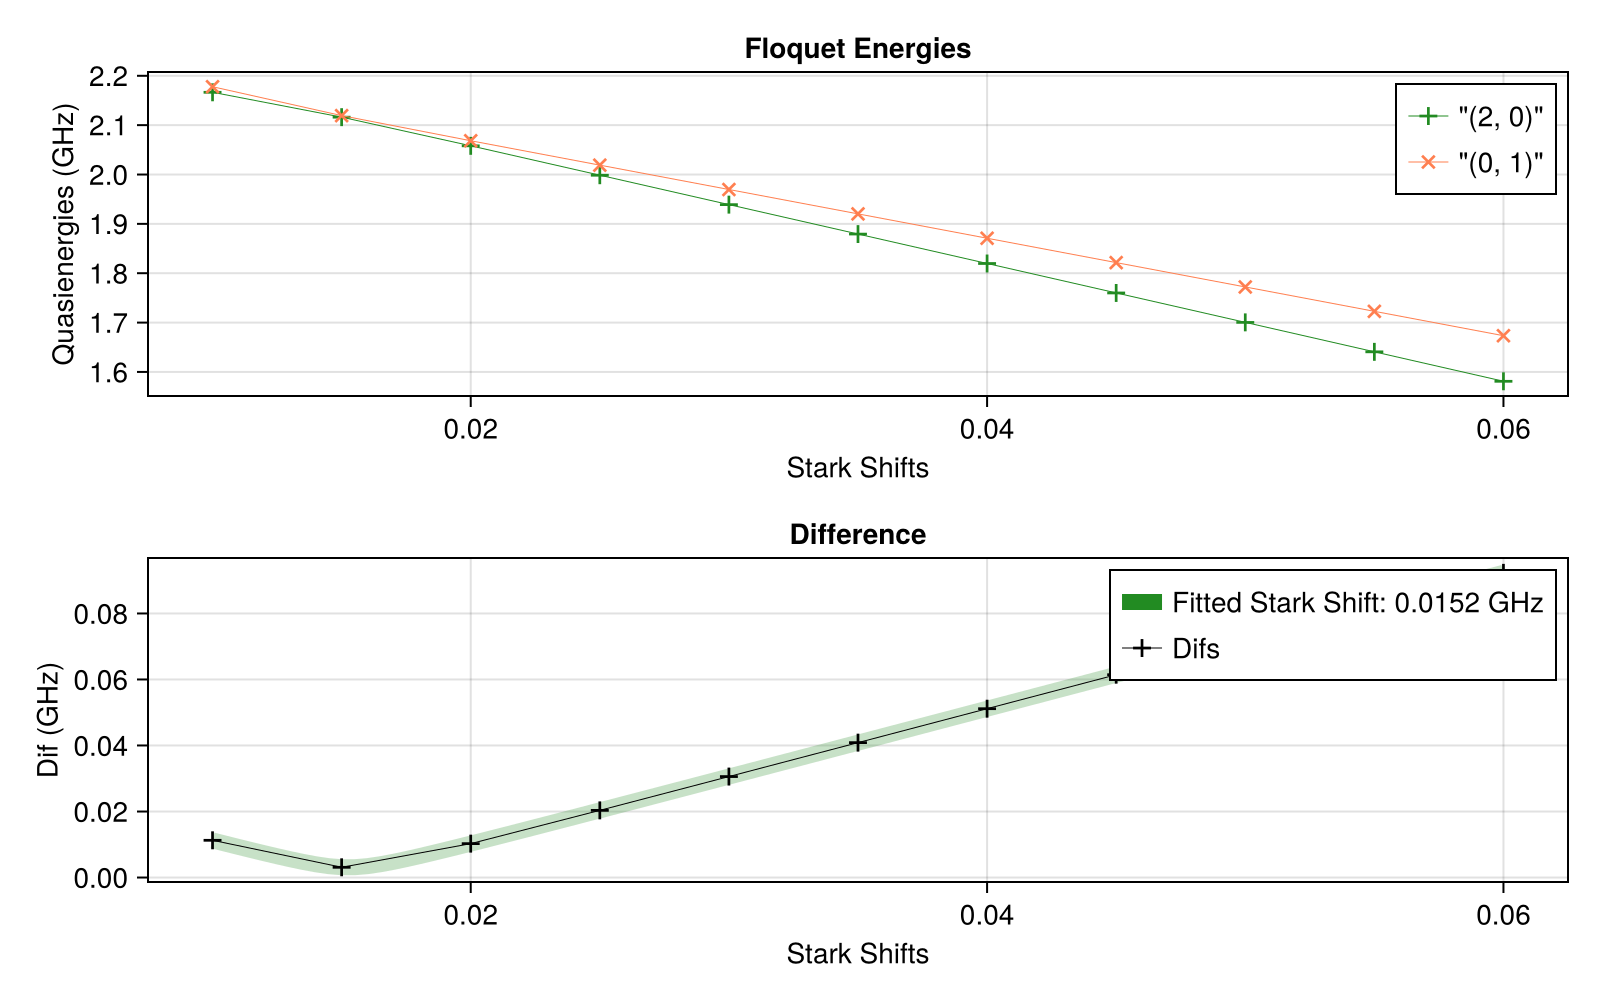

In [5]:
fngnp1_ε = 0.295
drive_op = Mode1.n̂ₜ
state1 = (2,0)
state2 = (0,1)

stark_shift_list = collect(LinRange(0.01, 0.06, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode1, state1, state2, fngnp1_ε, stark_shift_list)

println("Stark shift res: "*string(stark_shift_res))
fngnp1_stark_shift = stark_shift_res[1];
fngnp1_start_time = stark_shift_res[2];

In [123]:
fngnp1_ramp_time = 11.6257;

### f0->g1


In [124]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][1][1]*1000))

Target flattop time: 316.2202380952381


In [125]:
ψ1 = Mode1.dressed_states[(2,0)]
ψ2 = Mode1.dressed_states[(0,1)]

freq_d = Mode1.dressed_energies[(0,1)]-Mode1.dressed_energies[(2,0)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [fngnp1_start_time, fngnp1_start_time+fngnp1_ramp_time*2]

optimize_res_f0g1 = SC.Dynamics.OptimizePulse(Mode1, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-08 12:39:48] Info: On Level 1
[2024-11-08 12:39:48] Info: On Step 1: t = 324.81713806973005
[2024-11-08 12:39:48] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 06s (ETA: 0h 00m 00s)
[2024-11-08 12:39:55] Info: Time Evolution Complete
[2024-11-08 12:39:55] Info: Done with Level_1_step_1
[2024-11-08 12:39:55] Info: Accurace: 0.9957075624913371
[2024-11-08 12:39:55] Info: ------------------------------------------------------------------------------
[2024-11-08 12:39:55] Info: On Step 2: t = 330.6299880697301
[2024-11-08 12:39:55] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 06s (ETA: 0h 00m 00s)
[2024-11-08 12:40:02] Info: Time Evolution Complete
[2024-11-08 12:40:02] Info: Done with Level_1_step_2
[2024-11-08 12:40:02] Info: Accurace: 0.9985483733022704
[2024-11-08 12:40:02] Info: ------------------------------------------------------------------------------
[202

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 338.259
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>338.259, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.295
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0152459
  "accuracy"      => 0.999909
  "freq_d"        => -3.34906

In [126]:
optimize_res_f0g1["pulse_time"]-optimize_res_f0g1["Envelope Args"]["ramp_time"]*2

315.0079536947301

In [127]:
#Mode1.Stuff["op_drive_params"]["sb_f0g1"] = deepcopy(optimize_res_f0g1_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode1.Stuff["op_drive_params"]["sb_f0g1"] = deepcopy(optimize_res_f0g1)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 338.259
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>338.259, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.295
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0152459
  "accuracy"      => 0.999909
  "freq_d"        => -3.34906

In [128]:
ψ = Mode1.dressed_states[(2,0)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
sb_f0g1_res = SC.Dynamics.RunPulseSequence(Mode1, ψ, ["sb_f0g1"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T12:43:03.004
It is being saved at: Data/
[2024-11-08 12:43:03] Info: Running operator sb_f0g1
[2024-11-08 12:43:03] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 08s (ETA: 0h 00m 00s)
[2024-11-08 12:43:11] Info: Time Evolution Complete
[2024-11-08 12:43:11] Info: Saving Steps
[2024-11-08 12:43:11] Info: Done with Step_1
[2024-11-08 12:43:11] Info: Done With Running Sequence
[2024-11-08 12:43:11] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199917, 0.399834, 0.599751, 0.799668, 0.999584, 1.1995…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [129]:
EVs_f0g1 = SC.Utils.Get_EVs(sb_f0g1_res["states"], proj_dict);

[2024-11-08 12:43:12] Info: Making Plot


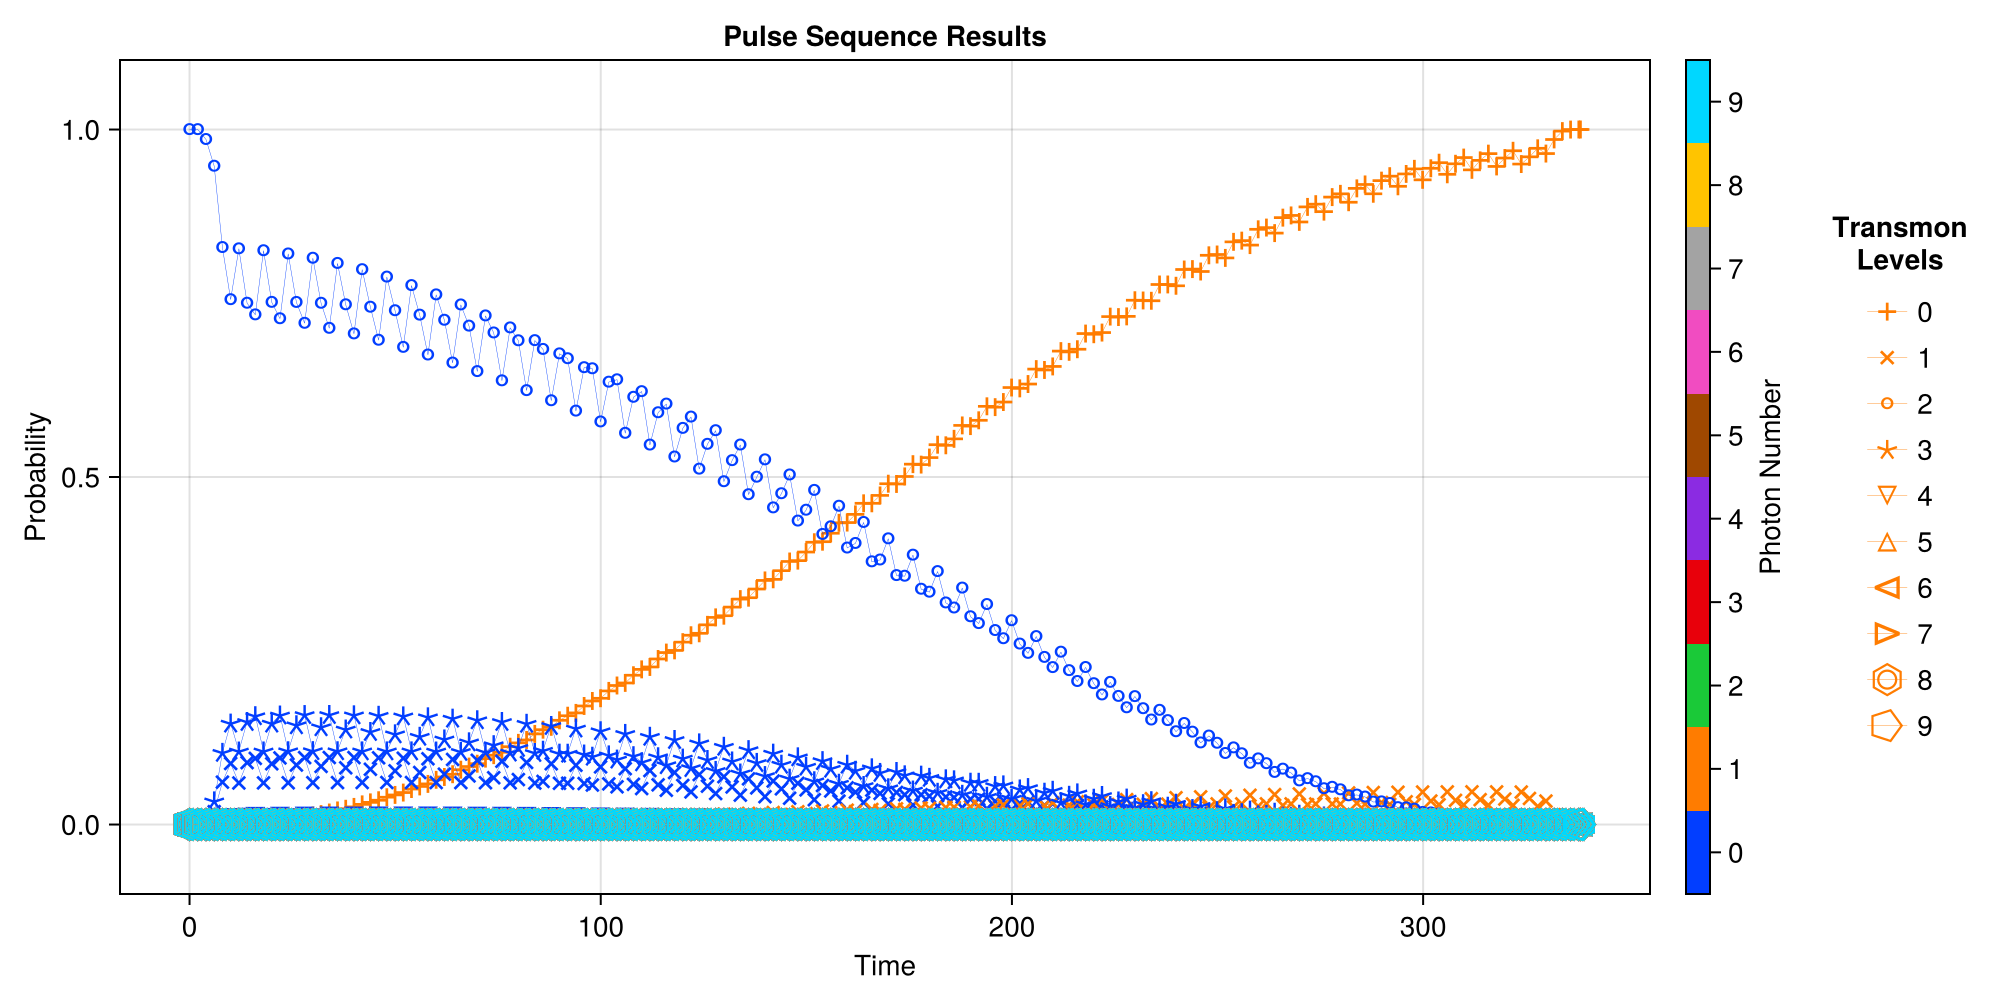

CairoMakie.Screen{IMAGE}


In [130]:
SC.Dynamics.PlotSingleModeEvolution(Mode1, sb_f0g1_res["times"], EVs_f0g1, plot_every = 10)

### f1->g2


In [144]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][1][2]*1000))

Target flattop time: 220.8891369047619


In [132]:
ψ1 = Mode1.dressed_states[(2,1)]
ψ2 = Mode1.dressed_states[(0,2)]

freq_d = Mode1.dressed_energies[(0,2)]-Mode1.dressed_energies[(2,1)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)


t_range = [fngnp1_start_time/sqrt(2), fngnp1_start_time/sqrt(2)+fngnp1_ramp_time*2]


optimize_res_f1g2 = SC.Dynamics.OptimizePulse(Mode1, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-08 12:43:13] Info: On Level 1
[2024-11-08 12:43:13] Info: On Step 1: t = 229.6804009747132
[2024-11-08 12:43:13] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-08 12:43:16] Info: Time Evolution Complete
[2024-11-08 12:43:16] Info: Done with Level_1_step_1
[2024-11-08 12:43:16] Info: Accurace: 0.9920369781452232
[2024-11-08 12:43:16] Info: ------------------------------------------------------------------------------
[2024-11-08 12:43:16] Info: On Step 2: t = 235.4932509747132
[2024-11-08 12:43:16] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-08 12:43:20] Info: Time Evolution Complete
[2024-11-08 12:43:20] Info: Done with Level_1_step_2
[2024-11-08 12:43:20] Info: Accurace: 0.9974885910879299
[2024-11-08 12:43:20] Info: ------------------------------------------------------------------------------
[2024

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 242.759
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>242.759, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.295
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0152459
  "accuracy"      => 0.999928
  "freq_d"        => -3.34873

In [133]:
optimize_res_f1g2["pulse_time"]-optimize_res_f1g2["Envelope Args"]["ramp_time"]*2

219.5079134747132

In [134]:
#Mode1.Stuff["op_drive_params"]["sb_f1g2"] = deepcopy(optimize_res_f1g2_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode1.Stuff["op_drive_params"]["sb_f1g2"] = deepcopy(optimize_res_f1g2)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 242.759
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>242.759, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.295
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0152459
  "accuracy"      => 0.999928
  "freq_d"        => -3.34873

### f2->g3

In [135]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][1][3]*1000))

Target flattop time: 179.03645833333334


In [136]:
ψ1 = Mode1.dressed_states[(2,2)]
ψ2 = Mode1.dressed_states[(0,3)]

freq_d = Mode1.dressed_energies[(0,3)]-Mode1.dressed_energies[(2,2)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [fngnp1_start_time/sqrt(3), fngnp1_start_time/sqrt(3)+fngnp1_ramp_time*2]

optimize_res_f2g3 = SC.Dynamics.OptimizePulse(Mode1, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-08 12:45:08] Info: On Level 1
[2024-11-08 12:45:08] Info: On Step 1: t = 187.5332621019625
[2024-11-08 12:45:08] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-08 12:45:12] Info: Time Evolution Complete
[2024-11-08 12:45:12] Info: Done with Level_1_step_1
[2024-11-08 12:45:12] Info: Accurace: 0.9882812803191193
[2024-11-08 12:45:12] Info: ------------------------------------------------------------------------------
[2024-11-08 12:45:12] Info: On Step 2: t = 193.3461121019625
[2024-11-08 12:45:12] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-08 12:45:16] Info: Time Evolution Complete
[2024-11-08 12:45:16] Info: Done with Level_1_step_2
[2024-11-08 12:45:16] Info: Accurace: 0.9962986273668513
[2024-11-08 12:45:16] Info: ------------------------------------------------------------------------------
[2024

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 200.612
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>200.612, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.295
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0152459
  "accuracy"      => 0.999776
  "freq_d"        => -3.3484

In [137]:
optimize_res_f2g3["pulse_time"]-optimize_res_f2g3["Envelope Args"]["ramp_time"]*2

177.3607746019625

In [138]:
#Mode1.Stuff["op_drive_params"]["sb_f2g3"] = deepcopy(optimize_res_f2g3_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode1.Stuff["op_drive_params"]["sb_f2g3"] = deepcopy(optimize_res_f2g3)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 200.612
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>200.612, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.295
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0152459
  "accuracy"      => 0.999776
  "freq_d"        => -3.3484

### f3->g4

In [139]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][1][4]*1000))

Target flattop time: 153.45982142857142


In [140]:
ψ1 = Mode1.dressed_states[(2,3)]
ψ2 = Mode1.dressed_states[(0,4)]

freq_d = Mode1.dressed_energies[(0,4)]-Mode1.dressed_energies[(2,3)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [fngnp1_start_time/sqrt(4), fngnp1_start_time/sqrt(4)+fngnp1_ramp_time*2]

optimize_res_f3g4 = SC.Dynamics.OptimizePulse(Mode1, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-08 12:46:50] Info: On Level 1
[2024-11-08 12:46:50] Info: On Step 1: t = 162.40856903486502
[2024-11-08 12:46:50] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-08 12:46:53] Info: Time Evolution Complete
[2024-11-08 12:46:53] Info: Done with Level_1_step_1
[2024-11-08 12:46:53] Info: Accurace: 0.9845425282739361
[2024-11-08 12:46:53] Info: ------------------------------------------------------------------------------
[2024-11-08 12:46:53] Info: On Step 2: t = 168.22141903486502
[2024-11-08 12:46:53] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-08 12:46:57] Info: Time Evolution Complete
[2024-11-08 12:46:57] Info: Done with Level_1_step_2
[2024-11-08 12:46:57] Info: Accurace: 0.9951014535983921
[2024-11-08 12:46:57] Info: ------------------------------------------------------------------------------
[20

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 175.124
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>175.124, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.295
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0152459
  "accuracy"      => 0.999605
  "freq_d"        => -3.34806

In [141]:
optimize_res_f3g4["pulse_time"]-optimize_res_f3g4["Envelope Args"]["ramp_time"]*2

151.872778409865

In [142]:
#Mode1.Stuff["op_drive_params"]["sb_f3g4"] = deepcopy(optimize_res_f3g4_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode1.Stuff["op_drive_params"]["sb_f3g4"] = deepcopy(optimize_res_f3g4)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 175.124
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>175.124, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.295
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0152459
  "accuracy"      => 0.999605
  "freq_d"        => -3.34806

## Other Specific Gates

### Special Side Bands

#### f1_2pi_g3

##### Getting Drive Strength and Stark Shift

In [54]:
n1 = 1
n2 = 3

freq1 = Mode1.dressed_energies[(2,n1)]-Mode1.dressed_energies[(0,n1+1)]
freq2 = Mode1.dressed_energies[(2,n2)]-Mode1.dressed_energies[(0,n2+1)]

χ = abs(freq1-freq2)
println("χ: $χ")

m = sqrt(2)^(abs(n2-n1)-1)
println("m: $m")

n = Int(floor(m/2)+1)
println("n: $n")

eps_f1_2pi_g3 = 1000*χ/(2*(4*n^2-m^2)^(1/2))*0.25
println("Required Epsilon: $eps_f1_2pi_g3")

χ: 0.0006688443824316437
m: 1.4142135623730951
n: 1
Required Epsilon: 0.05911804979699298


[2024-11-08 13:33:19] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


[2024-11-08 13:33:24] Info: Done With Floquet Sweep
[2024-11-08 13:33:24] Info: Fit Stuff: 3-element Vector{Float64}:	 0.0006248666922468885	 0.0004392035555927178	 2.0026769201675694


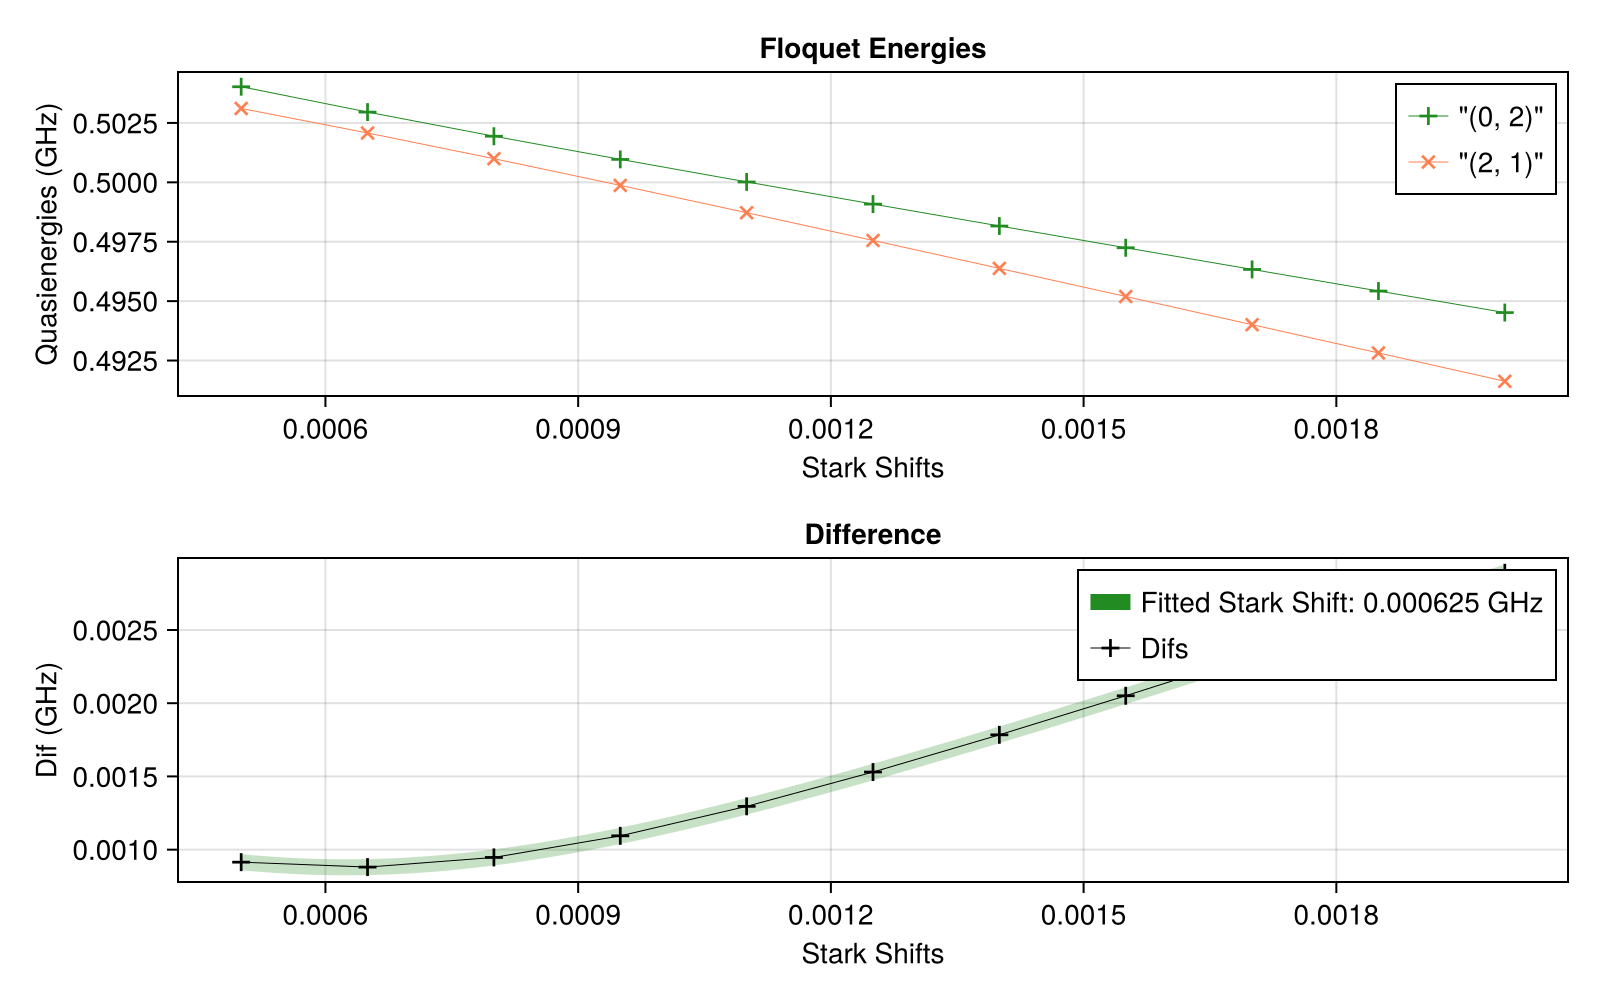

2-element Vector{Float64}:
    0.0006248666922468885
 1136.902600491557

In [55]:
ε = eps_f1_2pi_g3
drive_op = Mode1.n̂ₜ
state1 = (2,n1)
state2 = (0,n1+1)

#stark_shift_list = collect(LinRange(0.0005, 0.002, 11))
stark_shift_list = collect(LinRange(0.0005, 0.002, 11))

stark_shift_res_f0_2pi_g3 = SC.Dynamics.FindStarkShift(Mode1, state1, state2, ε, stark_shift_list)

##### Optimizing Pulse

In [56]:
n2

3

In [64]:
ψ1 = Mode1.dressed_states[(2,n1)]+Mode1.dressed_states[(2,n2)]
ψ1 = ψ1/qt.norm(ψ1)
ψ2 = Mode1.dressed_states[(0,n1+1)]+Mode1.dressed_states[(2,n2)]
ψ2 = ψ2/qt.norm(ψ2)


freq_d = Mode1.dressed_energies[(0,n1+1)]-Mode1.dressed_energies[(2, n1)]

ramp_time = 11.6257

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>ramp_time, "k" => 2, "pulse_time" => 0)

check_op = Mode1.dressed_states[(0,n1+1)]*Mode1.dressed_states[(2,n2)]'*2

stark_shift = stark_shift_res_f0_2pi_g3[1]
initial_time = stark_shift_res_f0_2pi_g3[2]

t_range = [initial_time*0.9, initial_time+5*ramp_time]

optimize_res_f1g2_2pi_f3g4 = SC.Dynamics.OptimizePulse(Mode1, ψ1, ψ2, eps_f1_2pi_g3, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 7, check_op = check_op);

[2024-11-08 13:35:42] Info: On Level 1
[2024-11-08 13:35:42] Info: On Step 1: t = 1023.2123404424013
[2024-11-08 13:35:42] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 21s (ETA: 0h 00m 00s)
[2024-11-08 13:36:04] Info: Time Evolution Complete
[2024-11-08 13:36:04] Info: Done with Level_1_step_1
[2024-11-08 13:36:04] Info: Using Check Op
[2024-11-08 13:36:04] Info: Accurace: 0.9718581345365798
[2024-11-08 13:36:04] Info: ------------------------------------------------------------------------------
[2024-11-08 13:36:04] Info: On Step 2: t = 1051.848800450594
[2024-11-08 13:36:04] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 24s (ETA: 0h 00m 00s)
[2024-11-08 13:36:28] Info: Time Evolution Complete
[2024-11-08 13:36:28] Info: Done with Level_1_step_2
[2024-11-08 13:36:28] Info: Using Check Op
[2024-11-08 13:36:28] Info: Accurace: 0.9852548904207307
[2024-11-08 13:36:28] Inf

In [65]:
optimize_res_f1g2_2pi_f3g4["pulse_time"] - optimize_res_f1g2_2pi_f3g4["Envelope Args"]["ramp_time"]*2

1085.8703204669791

In [66]:
#Mode1.Stuff["op_drive_params"]["sb_f1g2_2pi_f3g4"] = deepcopy(optimize_res_f1g2_2pi_f3g4)
if GLOBAL_SAVE_CALIBRATE | false
    Mode1.Stuff["op_drive_params"]["sb_f1g2_2pi_f3g4"] = deepcopy(optimize_res_f1g2_2pi_f3g4)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 1109.12
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>1109.12, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.059118
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000624867
  "accuracy"      => 0.998495
  "freq_d"        => -3.34873

In [67]:
ψ = Mode1.dressed_states[(2,1)]+Mode1.dressed_states[(2,3)]
ψ = ψ/sqrt(2)
res_f1g2_2pi_f3g4 = SC.Dynamics.RunPulseSequence(Mode1, ψ, ["sb_f1g2_2pi_f3g4"], Return = true, clean_up = true)

The Name for this run is: Operator_Sequence_2024-11-08T13:38:37.152
It is being saved at: Data/
[2024-11-08 13:38:37] Info: Running operator sb_f1g2_2pi_f3g4
[2024-11-08 13:38:37] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 25s (ETA: 0h 00m 00s)
[2024-11-08 13:39:02] Info: Time Evolution Complete
[2024-11-08 13:39:02] Info: Saving Steps
[2024-11-08 13:39:03] Info: Done with Step_1
[2024-11-08 13:39:03] Info: Done With Running Sequence
[2024-11-08 13:39:03] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199986, 0.399972, 0.599958, 0.799944, 0.999929, 1.1999…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [68]:
EVs_Dict = SC.Utils.Get_EVs(res_f1g2_2pi_f3g4["states"], proj_dict);

[2024-11-08 13:39:06] Info: Making Plot


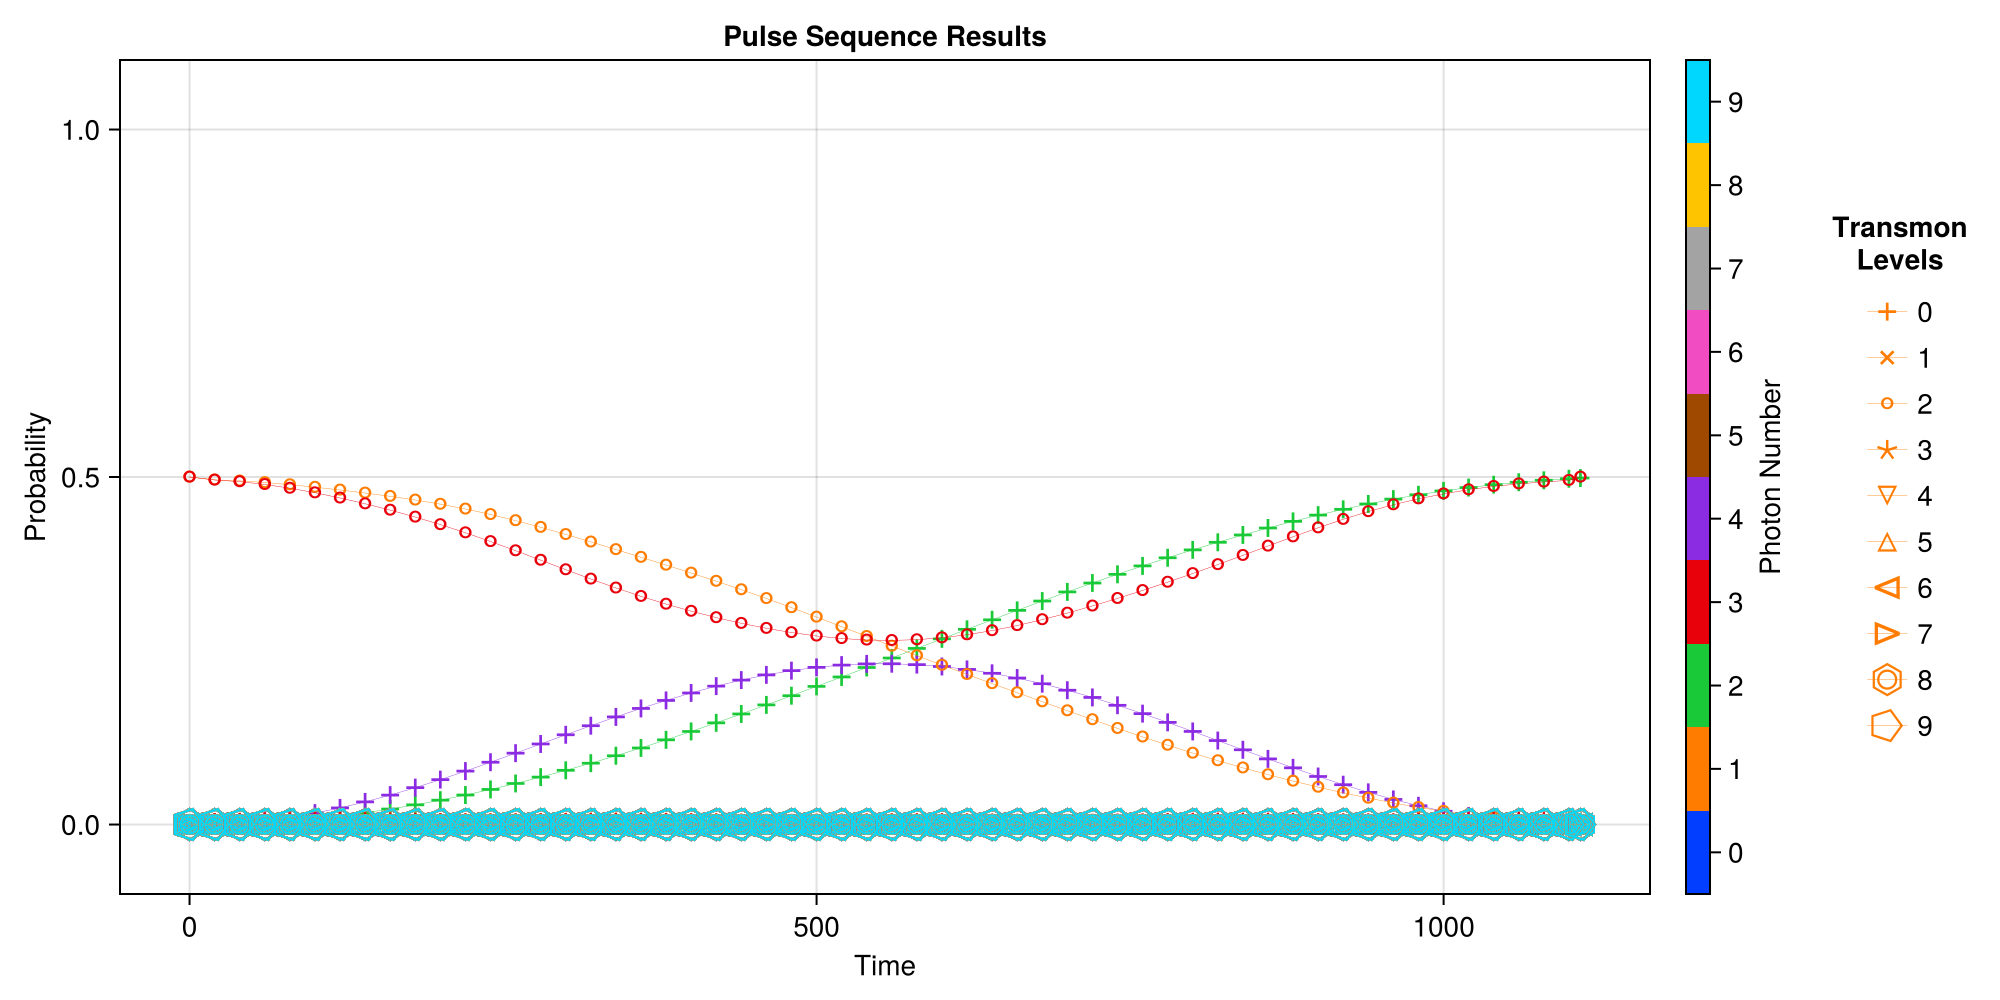

CairoMakie.Screen{IMAGE}


In [69]:
SC.Dynamics.PlotSingleModeEvolution(Mode1, res_f1g2_2pi_f3g4["times"], EVs_Dict, plot_every = 100)

In [70]:
println(EVs_Dict[(2,3)][end])
println(EVs_Dict[(0,2)][end])

0.4999943412754677 + 2.572421728835699e-17im
0.4985018961985759 + 8.775423893679049e-18im


#### f0_4pi_g3

##### Getting Drive Strength and Stark Shift

In [55]:
n1 = 0
n2 = 3

freq1 = Mode1.dressed_energies[(2,n1)]-Mode1.dressed_energies[(0,n1+1)]
freq2 = Mode1.dressed_energies[(2,n2)]-Mode1.dressed_energies[(0,n2+1)]

χ = abs(freq1-freq2)
println("χ: $χ")

m = sqrt(2)^(abs(n2-n1)-1)
println("m: $m")

n = Int(floor(m/2)+1)
println("n: $n")

eps_f0g1_4pi_f3g4 = 1000*χ/(2*(4*n^2-m^2)^(1/2))*0.385
println("Required Epsilon: $eps_f0g1_4pi_f3g4")

χ: 0.0010033860282590013
m: 2.0000000000000004
n: 2
Required Epsilon: 0.05575812487595772


[2024-11-08 16:32:51] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


[2024-11-08 16:33:08] Info: Done With Floquet Sweep
[2024-11-08 16:33:08] Info: Fit Stuff: 3-element Vector{Float64}:	 0.0005565040457934963	 0.0002930653646296101	 2.0023844947932403


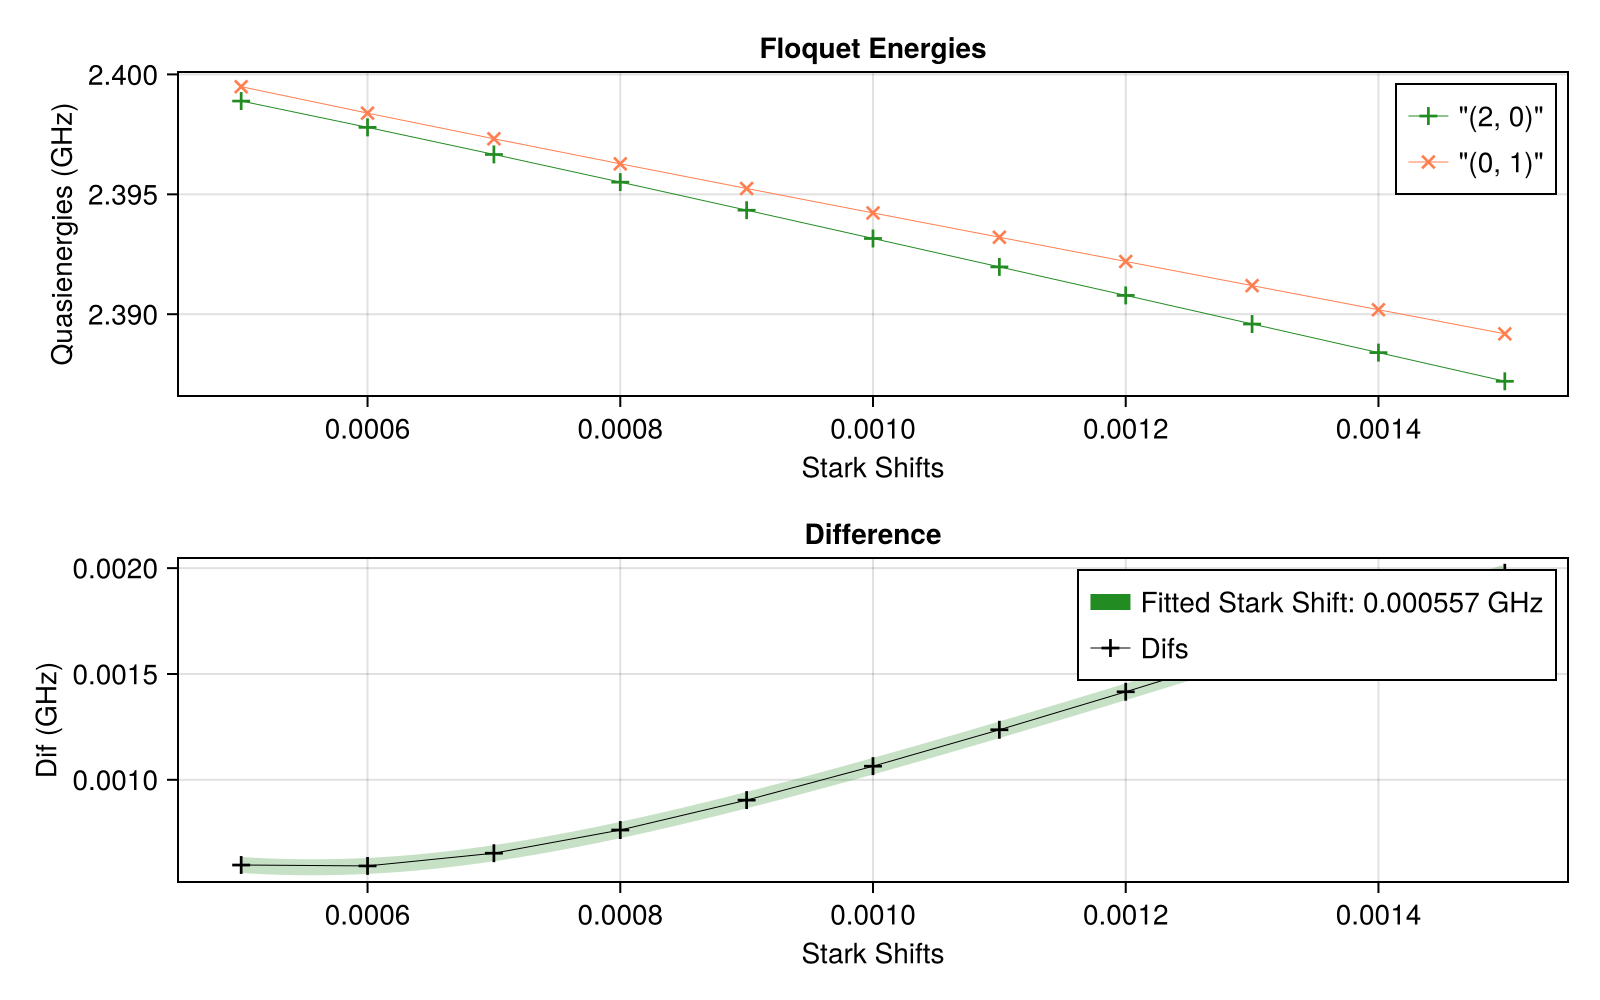

2-element Vector{Float64}:
    0.0005565040457934963
 1704.0723553717621

In [56]:
ε = eps_f0g1_4pi_f3g4
drive_op = Mode1.n̂ₜ
state1 = (2,n1)
state2 = (0,n1+1)

stark_shift_list = collect(LinRange(0.0005, 0.0015, 11))

stark_shift_res_f0g1_4pi_f3g4 = SC.Dynamics.FindStarkShift(Mode1, state1, state2, ε, stark_shift_list)

##### Optimizing Pulse

In [71]:
ψ1 = Mode1.dressed_states[(2,n1)]+Mode1.dressed_states[(2,n2)]
ψ1 = ψ1/qt.norm(ψ1)
ψ2 = Mode1.dressed_states[(0,n1+1)]+Mode1.dressed_states[(2,n2)]
ψ2 = ψ2/qt.norm(ψ2)

freq_d = Mode1.dressed_energies[(0,n1+1)]-Mode1.dressed_energies[(2, n1)]

check_op = 2*Mode1.dressed_states[(0,n1+1)]*Mode1.dressed_states[(2,n2)]'

ramp_time = 11.6257

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>ramp_time, "k" => 2, "pulse_time" => 0)

stark_shift = stark_shift_res_f0g1_4pi_f3g4[1]
initial_time = stark_shift_res_f0g1_4pi_f3g4[2]

ν = abs((stark_shift+freq_d))
t_range = [initial_time+2*ramp_time, initial_time+3*ramp_time]

optimize_res_f0g1_4pi_f3g4 = SC.Dynamics.OptimizePulse(Mode1, ψ1, ψ2, eps_f0g1_4pi_f3g4, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 5, check_op = check_op)

[2024-11-08 16:50:45] Info: On Level 1
[2024-11-08 16:50:45] Info: On Step 1: t = 1727.3237553717622
[2024-11-08 16:50:45] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 01m 04s (ETA: 0h 00m 00s)
[2024-11-08 16:51:50] Info: Time Evolution Complete
[2024-11-08 16:51:50] Info: Done with Level_1_step_1
[2024-11-08 16:51:50] Info: Using Check Op
[2024-11-08 16:51:50] Info: Accurace: 0.9996871143457293
[2024-11-08 16:51:50] Info: ------------------------------------------------------------------------------
[2024-11-08 16:51:50] Info: On Step 2: t = 1730.2301803717621
[2024-11-08 16:51:50] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 26s (ETA: 0h 00m 00s)
[2024-11-08 16:52:17] Info: Time Evolution Complete
[2024-11-08 16:52:17] Info: Done with Level_1_step_2
[2024-11-08 16:52:17] Info: Using Check Op
[2024-11-08 16:52:17] Info: Accurace: 0.9997021095305425
[2024-11-08 16:52:17] In

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 1730.23
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>1730.23, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.0557581
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000556504
  "accuracy"      => 0.999702
  "freq_d"        => -3.34906

In [72]:
#Mode1.Stuff["op_drive_params"]["sb_f0g1_4pi_f3g4"] = deepcopy(optimize_res_f0g1_4pi_f3g4)
if GLOBAL_SAVE_CALIBRATE | false
    Mode1.Stuff["op_drive_params"]["sb_f0g1_4pi_f3g4"] = deepcopy(optimize_res_f0g1_4pi_f3g4)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 1730.23
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>1730.23, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.0557581
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000556504
  "accuracy"      => 0.999702
  "freq_d"        => -3.34906

In [73]:
ψ = Mode1.dressed_states[(2,0)]+Mode1.dressed_states[(2,3)]
ψ = ψ/sqrt(2)
res_f0g1_4pi_f3g4 = SC.Dynamics.RunPulseSequence(Mode1, ψ, ["sb_f0g1_4pi_f3g4"], Return = true, clean_up = true, spns = 1)

The Name for this run is: Operator_Sequence_2024-11-08T16:53:38.357
It is being saved at: Data/
[2024-11-08 16:53:38] Info: Running operator sb_f0g1_4pi_f3g4
[2024-11-08 16:53:38] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 28s (ETA: 0h 00m 00s)
[2024-11-08 16:54:06] Info: Time Evolution Complete
[2024-11-08 16:54:06] Info: Saving Steps
[2024-11-08 16:54:07] Info: Done with Step_1
[2024-11-08 16:54:07] Info: Done With Running Sequence
[2024-11-08 16:54:07] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.999555, 1.99911, 2.99867, 3.99822, 4.99778, 5.99733, 6…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [74]:
EVs_Dict = SC.Utils.Get_EVs(res_f0g1_4pi_f3g4["states"], proj_dict);

[2024-11-08 16:54:08] Info: Making Plot


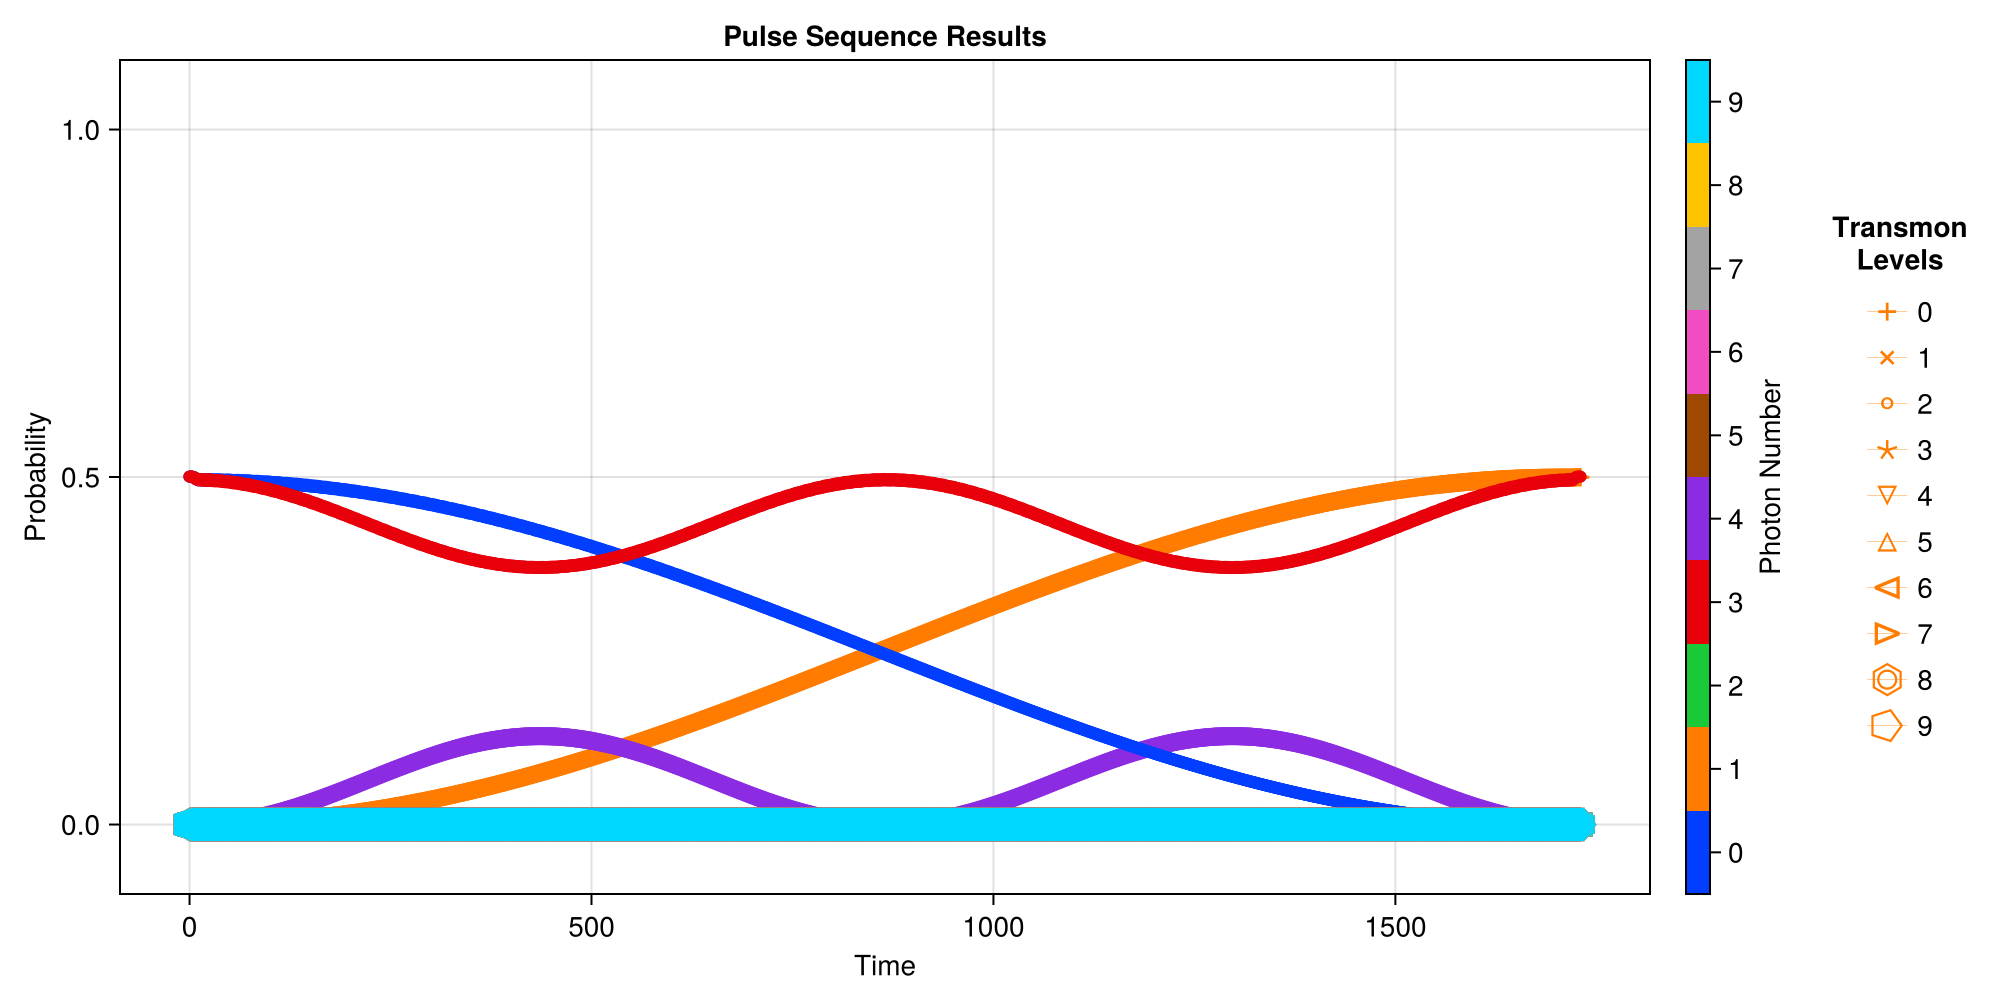

CairoMakie.Screen{IMAGE}


In [75]:
SC.Dynamics.PlotSingleModeEvolution(Mode1, res_f0g1_4pi_f3g4["times"], EVs_Dict)

In [76]:
println(EVs_Dict[(2,3)][end])
println(EVs_Dict[(0,1)][end])

0.4999812103293717 - 2.2434225888692367e-17im
0.49970725790504394 - 1.5621669787156542e-17im


#### Half Sideband $|f1\rangle \to |f1\rangle+|g2\rangle$

In [79]:
Mode1.Stuff["op_drive_params"]["sb_f1g2"]["pulse_time"]

242.7593134747132

In [94]:
starting_args = deepcopy(Mode1.Stuff["op_drive_params"]["sb_f1g2"])

envelope_args = starting_args["Envelope Args"]
envelope = starting_args["Envelope"]
freq_d = starting_args["freq_d"]
stark_shift = starting_args["shift"]
ε = starting_args["epsilon"]

ψ1 = Mode1.dressed_states[(2,1)]
ψ2 = Mode1.dressed_states[(2,1)] + Mode1.dressed_states[(0,2)]
ψ2 = ψ2/sqrt(2)

proj_op = Mode1.dressed_states[(2,1)]*Mode1.dressed_states[(0,2)]'
op = 2*proj_op# proj_dict[(2,1)]+proj_dict[(0,2)]


t_range = [69.8, 70.2]
t_range = [70.8, 71.2]
t_range = [60, 88]
t_range = [starting_args["pulse_time"]*0.5, starting_args["pulse_time"]*0.8]


optimize_res_half_f1g2 = SC.Dynamics.OptimizePulse(Mode1, ψ1, ψ2, ε, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 25, check_op = op)

[2024-11-08 16:58:08] Info: On Level 1
[2024-11-08 16:58:08] Info: On Step 1: t = 121.3796567373566
[2024-11-08 16:58:08] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 16:58:09] Info: Time Evolution Complete
[2024-11-08 16:58:09] Info: Done with Level_1_step_1
[2024-11-08 16:58:09] Info: Using Check Op
[2024-11-08 16:58:09] Info: Accurace: 0.9967545281860856
[2024-11-08 16:58:09] Info: ------------------------------------------------------------------------------
[2024-11-08 16:58:09] Info: On Step 2: t = 124.41414815579051
[2024-11-08 16:58:09] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-08 16:58:12] Info: Time Evolution Complete
[2024-11-08 16:58:12] Info: Done with Level_1_step_2
[2024-11-08 16:58:12] Info: Using Check Op
[2024-11-08 16:58:12] Info: Accurace: 0.9992272108560769
[2024-11-08 16:58:12] Inf

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 127.449
  "Envelope Args" => Dict{String, Any}("pulse_time"=>127.449, "k"=>2, "ramp_tim…
  "epsilon"       => 0.295
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0152459
  "accuracy"      => 0.999997
  "freq_d"        => -3.34873

In [95]:
#Mode1.Stuff["op_drive_params"]["sb_half_f1g2"] = deepcopy(optimize_res_half_f1g2)
if GLOBAL_SAVE_CALIBRATE | false
    Mode1.Stuff["op_drive_params"]["sb_half_f1g2"] = deepcopy(optimize_res_half_f1g2)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 127.449
  "Envelope Args" => Dict{String, Any}("pulse_time"=>127.449, "k"=>2, "ramp_tim…
  "epsilon"       => 0.295
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0152459
  "accuracy"      => 0.999997
  "freq_d"        => -3.34873

In [96]:
ψ = Mode1.dressed_states[(2,1)]
res_half_f1g2 = SC.Dynamics.RunPulseSequence(Mode1, ψ, ["sb_half_f1g2"], Return = true, clean_up = true)

The Name for this run is: Operator_Sequence_2024-11-08T16:59:20.403
It is being saved at: Data/
[2024-11-08 16:59:20] Info: Running operator sb_half_f1g2
[2024-11-08 16:59:20] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-08 16:59:22] Info: Time Evolution Complete
[2024-11-08 16:59:22] Info: Saving Steps
[2024-11-08 16:59:23] Info: Done with Step_1
[2024-11-08 16:59:23] Info: Done With Running Sequence
[2024-11-08 16:59:23] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199763, 0.399526, 0.599288, 0.799051, 0.998814, 1.1985…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [97]:
EVs_Dict = SC.Utils.Get_EVs(res_half_f1g2["states"], proj_dict);

[2024-11-08 16:59:23] Info: Making Plot


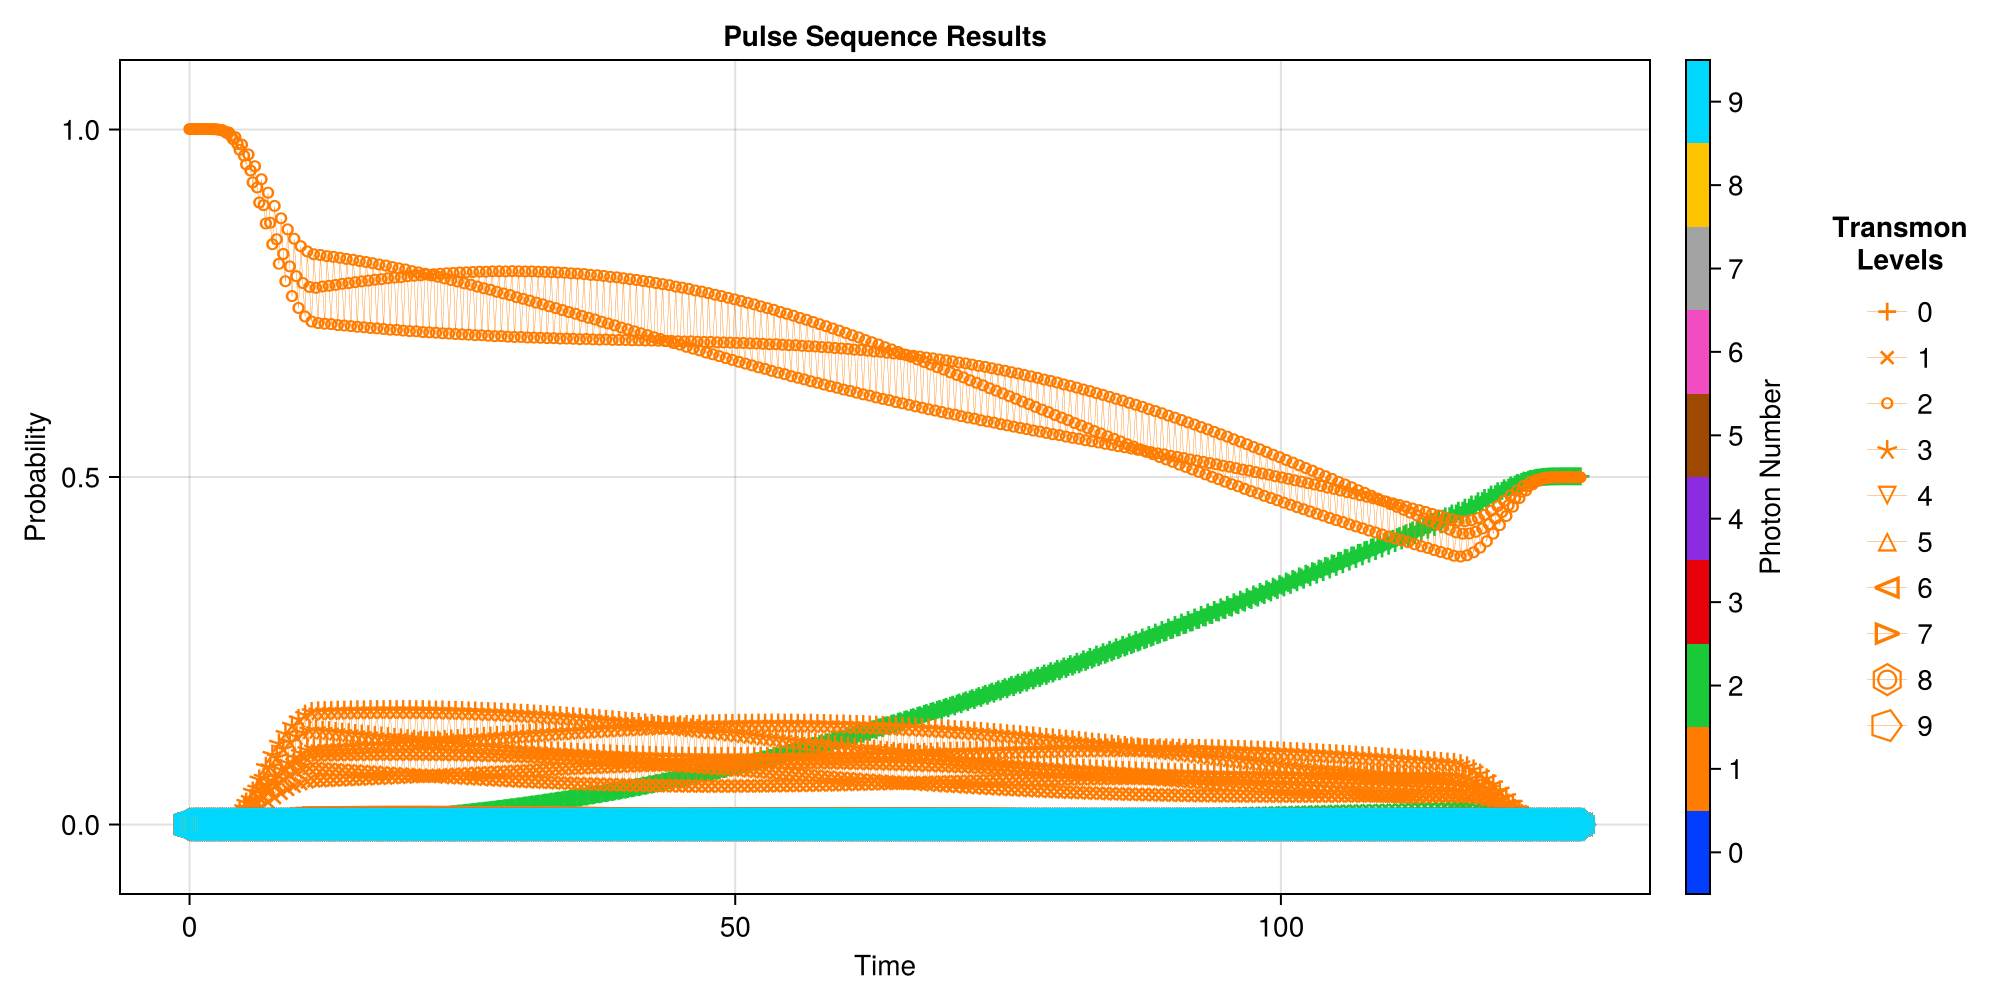

CairoMakie.Screen{IMAGE}


In [98]:
SC.Dynamics.PlotSingleModeEvolution(Mode1, res_half_f1g2["times"], EVs_Dict)

In [99]:
println(EVs_Dict[(2,1)][end])
println(EVs_Dict[(0,2)][end])

0.4990083278429992 + 2.1536157557573482e-20im
0.5009910407737541 - 2.0213457811824494e-17im
